### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import xgboost as xgb
import itertools
import warnings



Periode  thuis opladen  elektrische auto  hybride elektrisch  \
0    2007-03-01              0                 0                   0   
1    2007-04-01              0                 0                   0   
2    2007-05-01              0                 2                   0   
3    2007-06-01              0                 2                   0   
4    2007-07-01              0                 1                   0   
..          ...            ...               ...                 ...   
210  2024-09-01             57                52                  59   
211  2024-10-01             79                50                  63   
212  2024-11-01             68                48                  46   
213  2024-12-01             69                46                  60   
214  2025-01-01             72                44                  58   

     Bijtellingspercentage  Consumentenvertrouwen  Economisch klimaat  \
0                        0                  20.00                37.0   
1                        0                  20.00                37.0   
2                        0                  18.00                32.0   
3                        0                  16.00                27.0   
4                        0                  14.00                22.0   
..                     ...                    ...                 ...   
210                     16                 -21.00               -37.0   
211                     16                 -23.00               -40.0   
212                     16                 -25.00               -43.0   
213                     16                 -26.00               -45.0   
214                     17                 -28.75               -49.0   

     Koopbereidheid  Grote aankopen  BenzineEuro95_1_first  ...  \
0              9.00            8.00                  1.365  ...   
1              9.00            8.00                  1.414  ...   
2              9.00            7.40                  1.452  ...   
3              9.00            6.80                  1.458  ...   
4              9.00            6.20                  1.451  ...   
..              ...             ...                    ...  ...   
210          -11.00          -29.00                  1.912  ...   
211          -11.50          -28.50                  1.860  ...   
212          -12.00          -28.00                  1.914  ...   
213          -13.00          -27.00                  1.953  ...   
214          -14.75          -28.75                  1.942  ...   

     BenzineEuro95_1_max  BenzineEuro95_1_mean  Diesel_2_first  Diesel_2_last  \
0                  1.416              1.379032           1.003          1.038   
1                  1.451              1.426500           1.036          1.026   
2                  1.483              1.466516           1.028          1.037   
3                  1.461              1.454600           1.035          1.057   
4                  1.469              1.443903           1.057          1.064   
..                   ...                   ...             ...            ...   
210                1.916              1.879633           1.635          1.589   
211                1.926              1.902806           1.588          1.649   
212                1.986              1.947800           1.652          1.744   
213                1.958              1.947871           1.740          1.720   
214                1.979              1.960935           1.719          1.752   

     Diesel_2_min  Diesel_2_max  Diesel_2_mean  \
0           0.995         1.038       1.006323   
1           1.019         1.039       1.030600   
2           1.021         1.047       1.032323   
3           1.035         1.066       1.053433   
4           1.057         1.069       1.063484   
..            ...           ...            ...   
210         1.584         1.640       1.607667   
211         1.587         1.660       1.640419   
212         1.648         1.774       

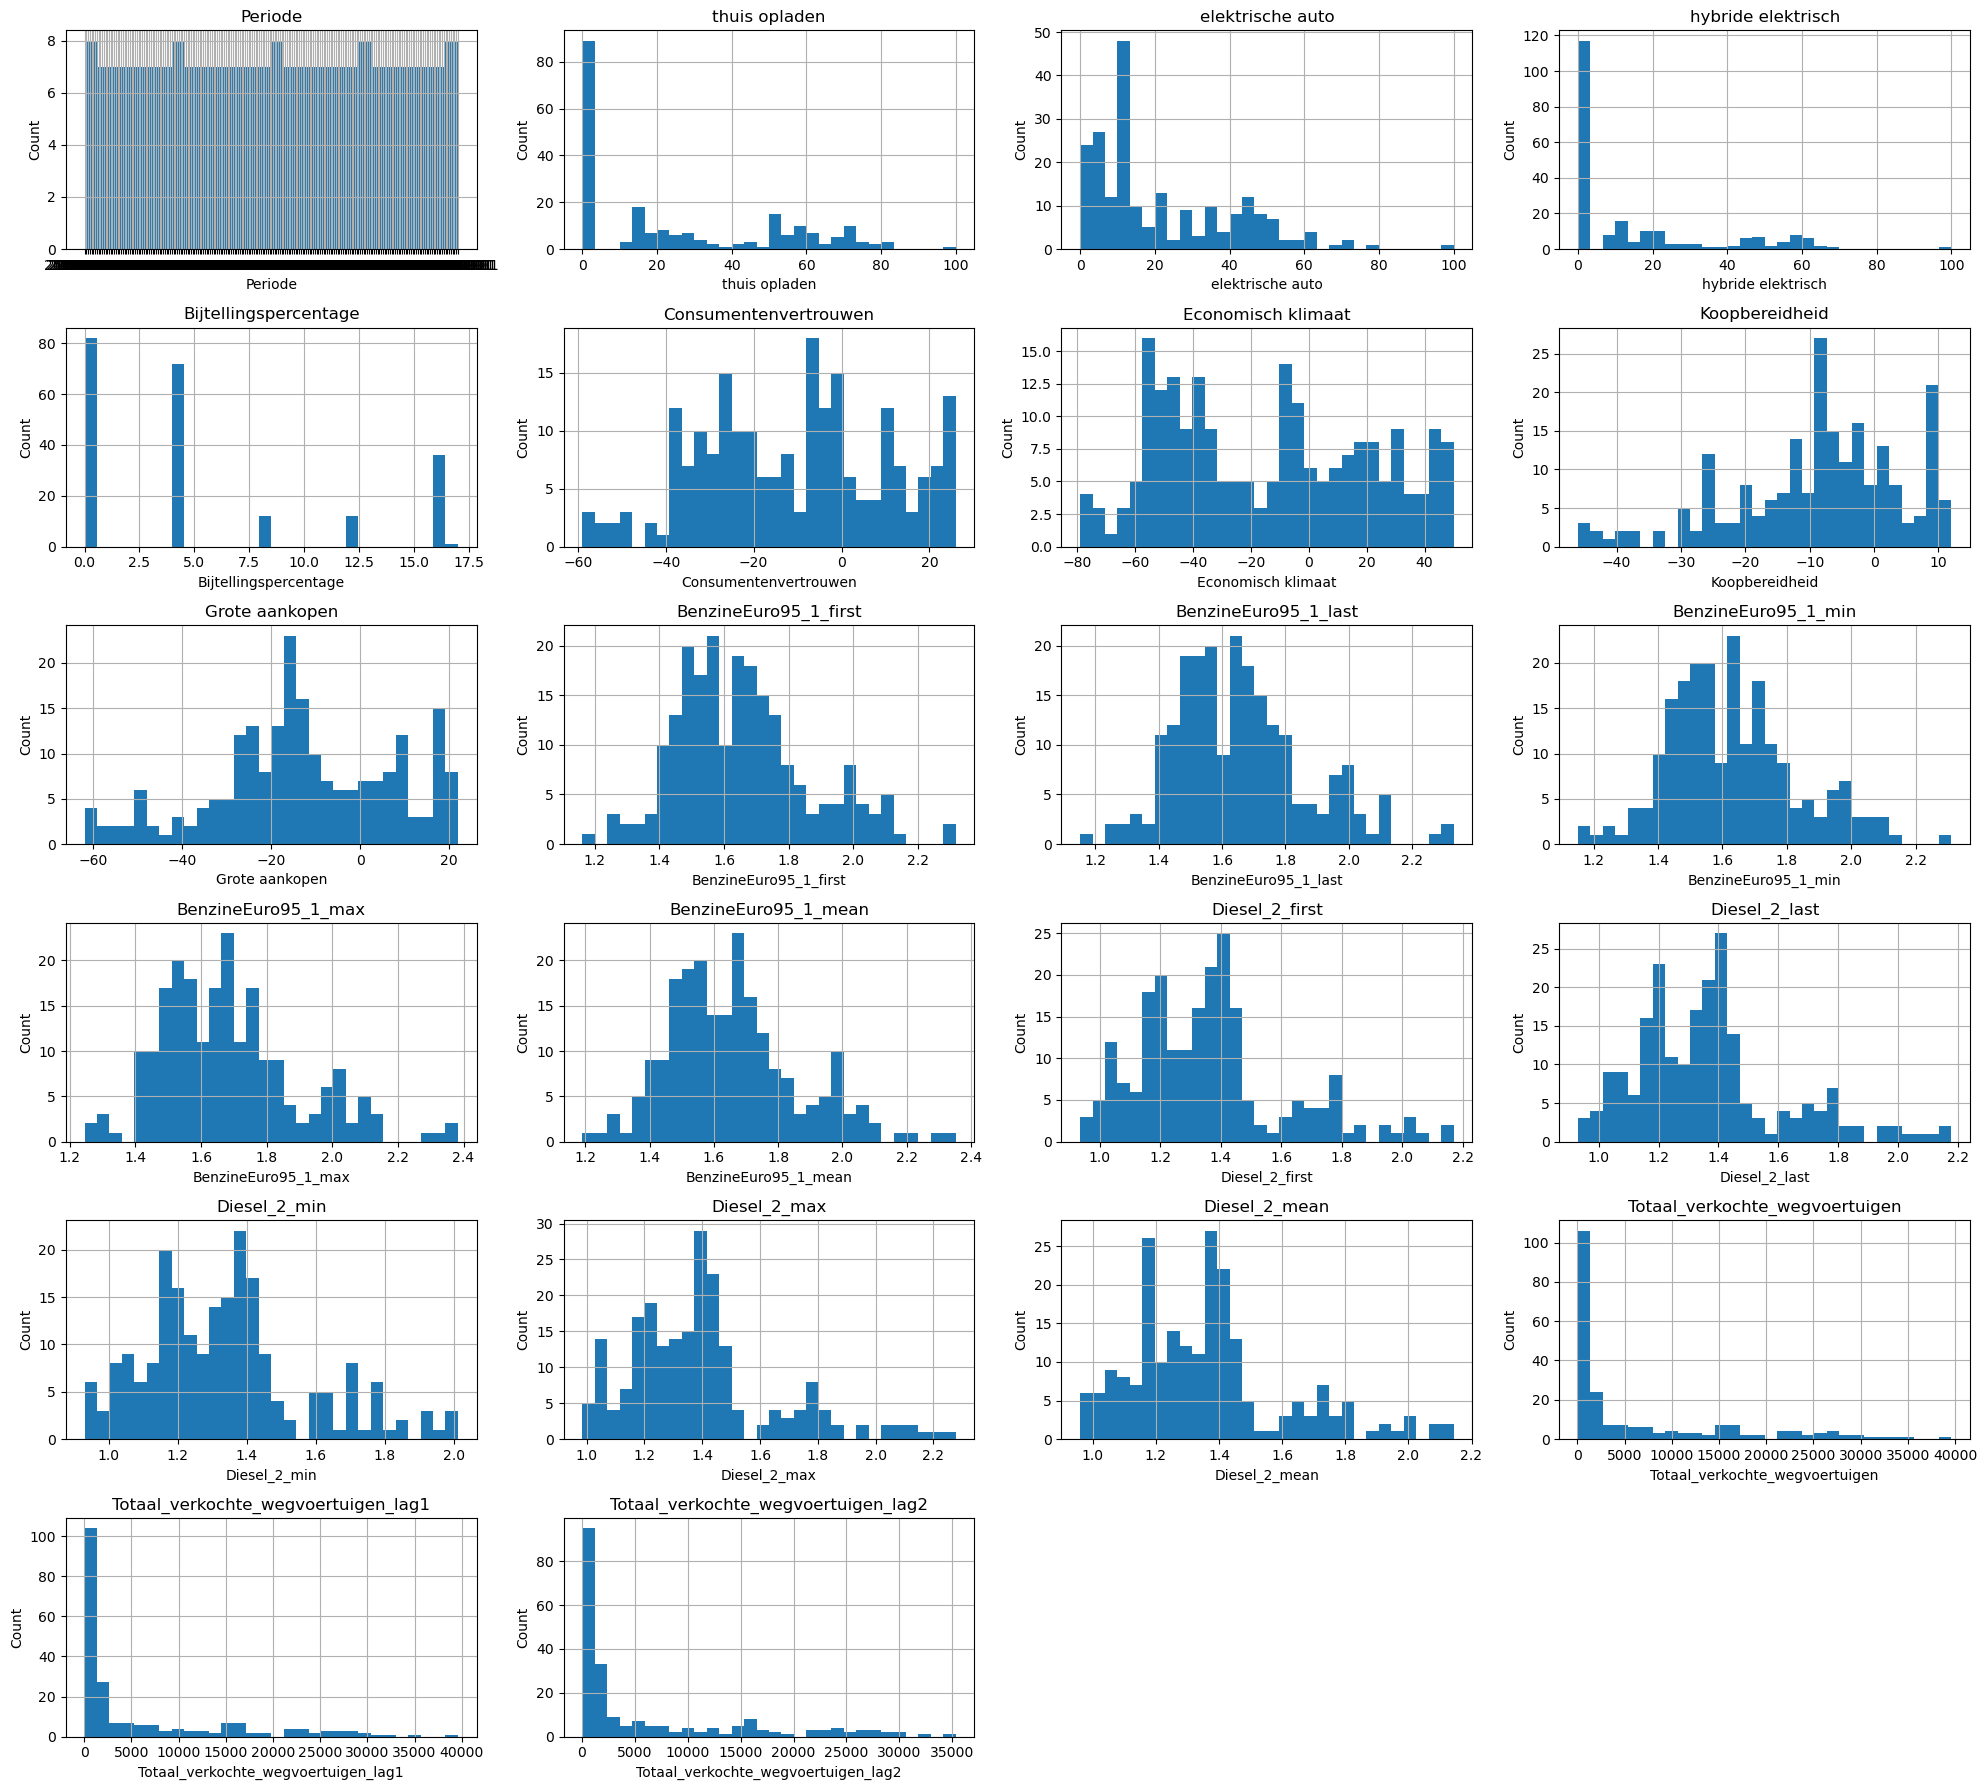

In [11]:
df_lagged = pd.read_csv(r'E:\Nieuw dataset\Timeseriessplit\evsales_trends_lagged_sales2_google0.csv')
display(df_lagged)

import matplotlib.pyplot as plt

# Plot all histograms in a single large PNG with subplots
import matplotlib.pyplot as plt

num_cols = len(df_lagged.columns)
n_cols = 4
n_rows = int(np.ceil(num_cols / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 3))
axes = axes.flatten()

for i, col in enumerate(df_lagged.columns):
    df_lagged[col].hist(bins=30, ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")

# Remove unused axes
for j in range(num_cols, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig("all_histograms.png", dpi=200)
plt.show()

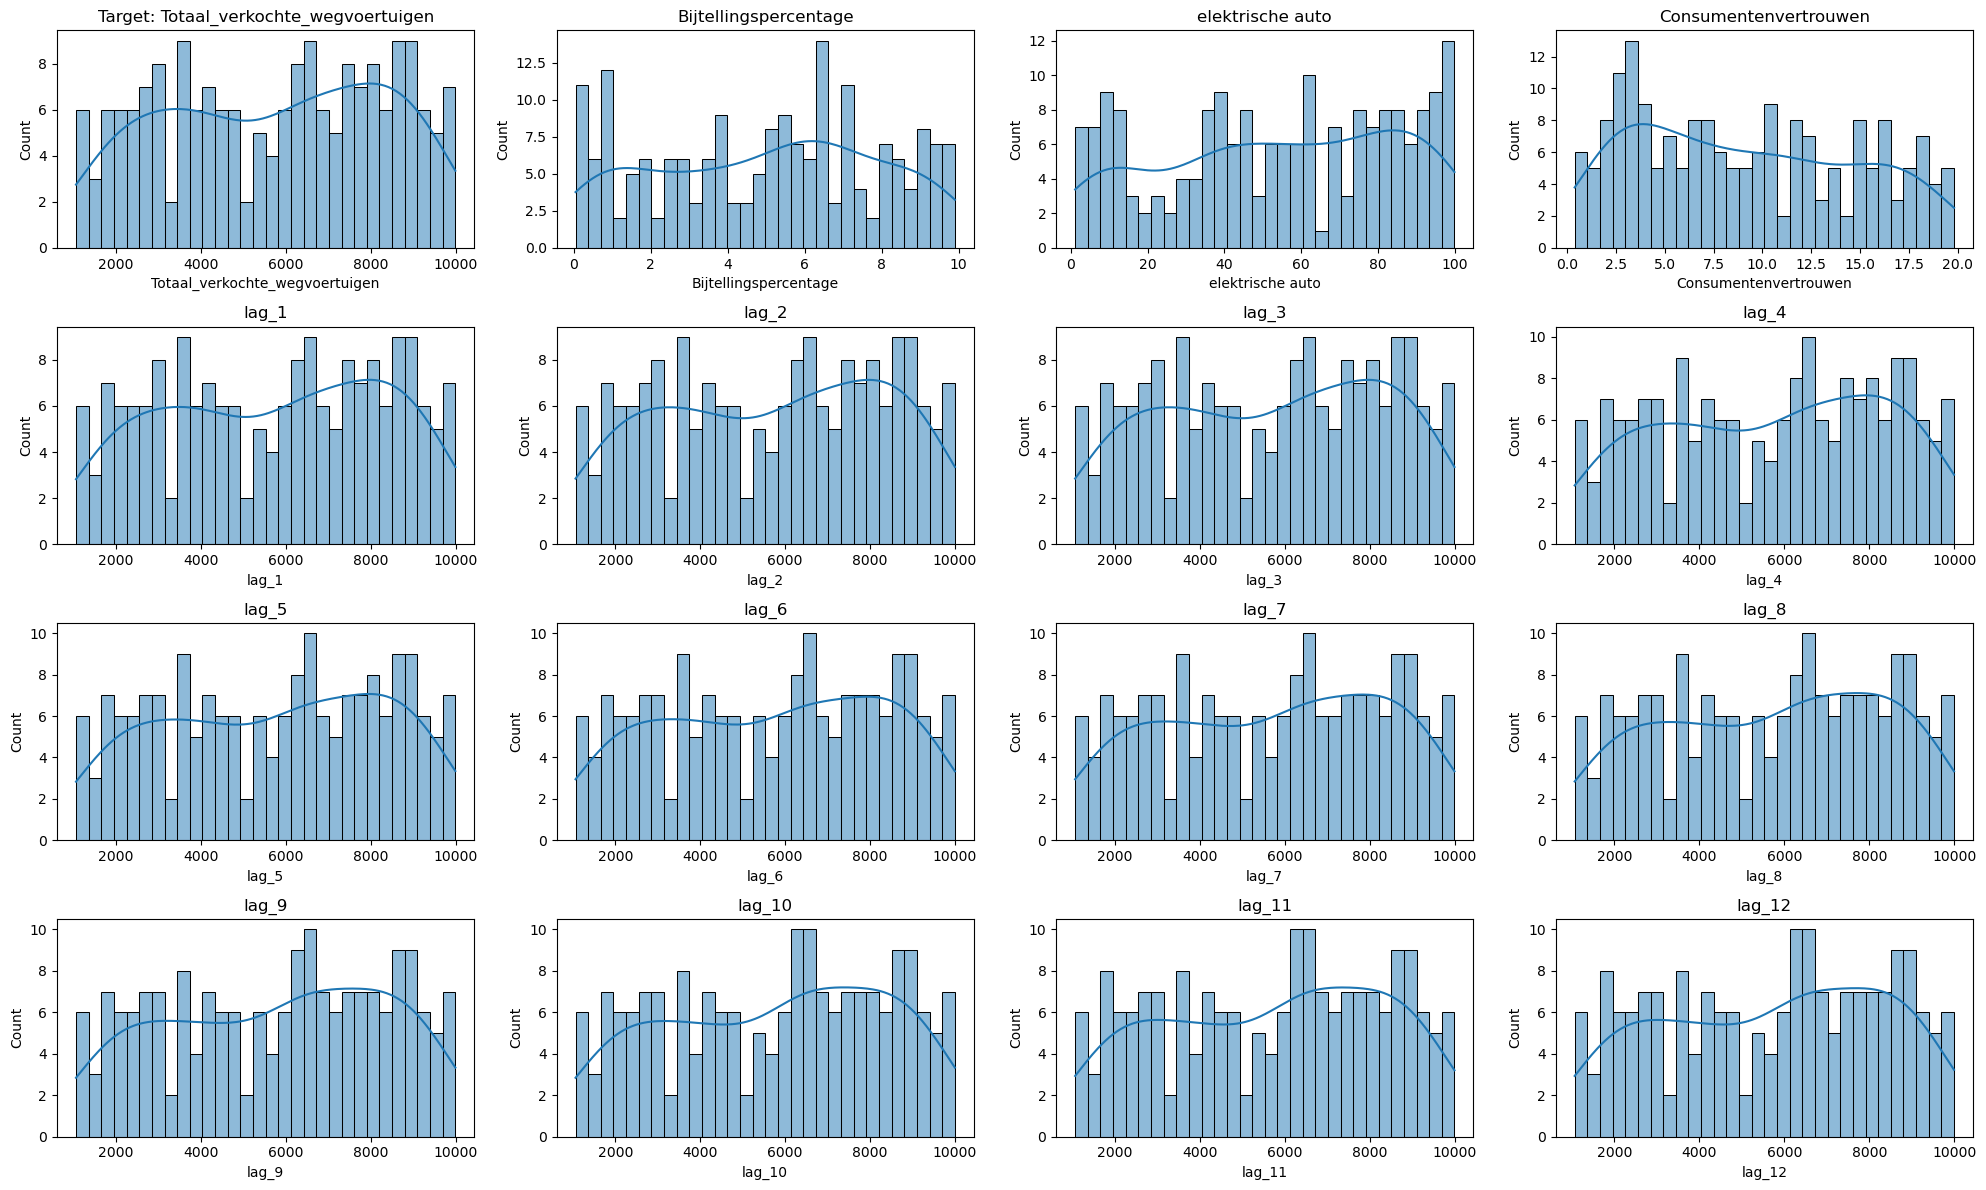

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the distribution for every column in X and y
n_cols = len(X.columns) + 1
n_rows = int(np.ceil(n_cols / 4))
fig, axes = plt.subplots(n_rows, 4, figsize=(20, n_rows * 3))
axes = axes.flatten()

# Plot target
sns.histplot(y, kde=True, bins=30, ax=axes[0])
axes[0].set_title("Target: Totaal_verkochte_wegvoertuigen")

# Plot each feature
for i, col in enumerate(X.columns):
    sns.histplot(X[col], kde=True, bins=30, ax=axes[i + 1])
    axes[i + 1].set_title(col)

# Remove unused axes
for j in range(n_cols, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Time series split

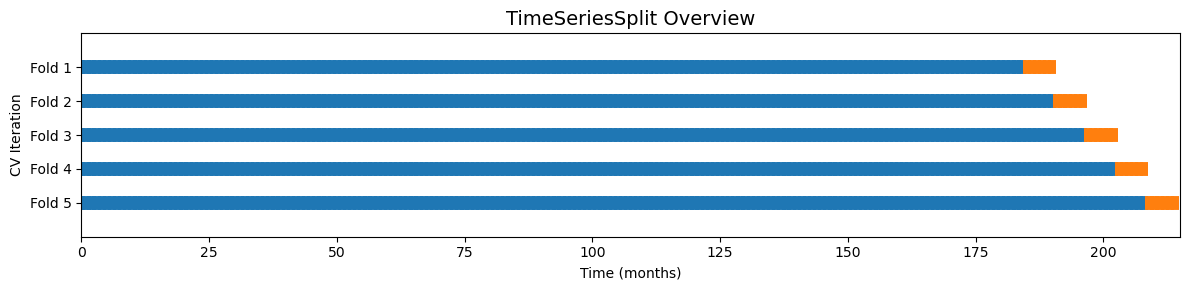

In [3]:
# --- Load your data ---
df = df_lagged.copy()
df['Periode'] = pd.to_datetime(df['Periode'])
df.sort_values('Periode', inplace=True)
X = df.drop(columns=['Totaal_verkochte_wegvoertuigen', 'Periode'])
y = df['Totaal_verkochte_wegvoertuigen']

# --- Define TimeSeriesSplit ---
n_splits = 5
test_size = 6
tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size)

# --- Custom color map for CV ---
cmap_cv = mcolors.ListedColormap(["#1f77b4", "#ff7f0e"])  # Blue for train, Orange for test

# --- Plot function ---
def plot_cv_indices(cv, X, y, ax, lw=10):
    for ii, (train_index, test_index) in enumerate(cv.split(X=X)):
        indices = np.full(len(X), np.nan)
        indices[train_index] = 0
        indices[test_index] = 1

        ax.scatter(
            range(len(X)),
            [ii + 0.5] * len(X),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

    ax.set(
        yticks=np.arange(n_splits) + 0.5,
        yticklabels=[f"Fold {i+1}" for i in range(n_splits)],
        xlabel="Time (months)",
        ylabel="CV Iteration",
        ylim=[n_splits + 0.5, -0.5],
        xlim=[0, len(X)],
    )
    ax.set_title("TimeSeriesSplit Overview", fontsize=14)

# --- Run and plot ---
fig, ax = plt.subplots(figsize=(12, 3))
plot_cv_indices(tscv, X, y, ax)
plt.tight_layout()
plt.show()


#### Model 1 (Arima) 
Average performance over all folds:
Average RMSE: 4187.59
Average MAE: 3496.14
Average MAPE / Error margin (%): 15.31
Average R²: -1.00

ARIMA is a widely used model for time series analysis. It is a statistical model that uses past values to predict future values of a time series. ARIMA models are widely used in fields like finance, economics, and meteorology. The model works well when the data has a clear trend, seasonality, and is stationary.

https://medium.com/@yennhi95zz/a-guide-to-time-series-models-in-machine-learning-usage-pros-and-cons-ac590a75e8b3 


Fold 1
Train: 2007-03-01 to 2022-01-01
Validation: 2022-02-01 to 2022-07-01
RMSE: 2307.82
MAE: 1800.49
MAPE / Error margin (%): 12.28


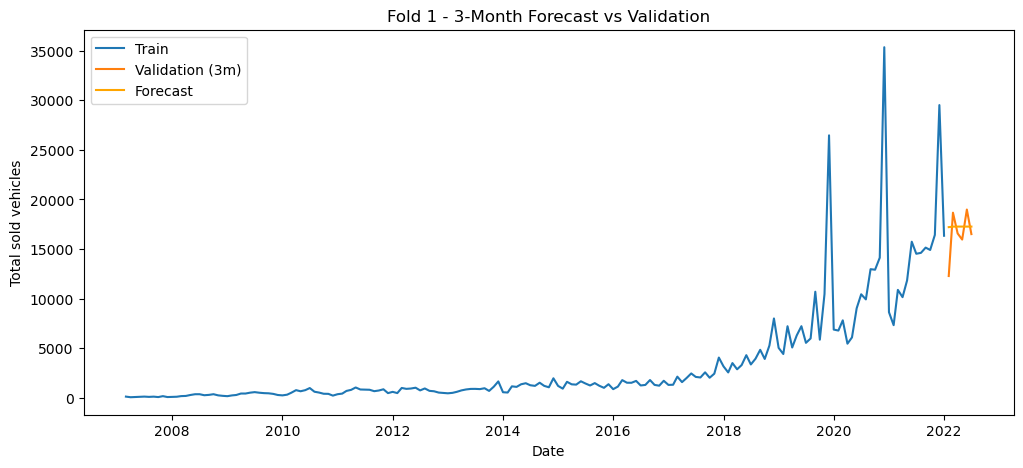


Fold 2
Train: 2007-03-01 to 2023-01-01
Validation: 2023-02-01 to 2023-07-01
RMSE: 6979.89
MAE: 5757.91
MAPE / Error margin (%): 22.75


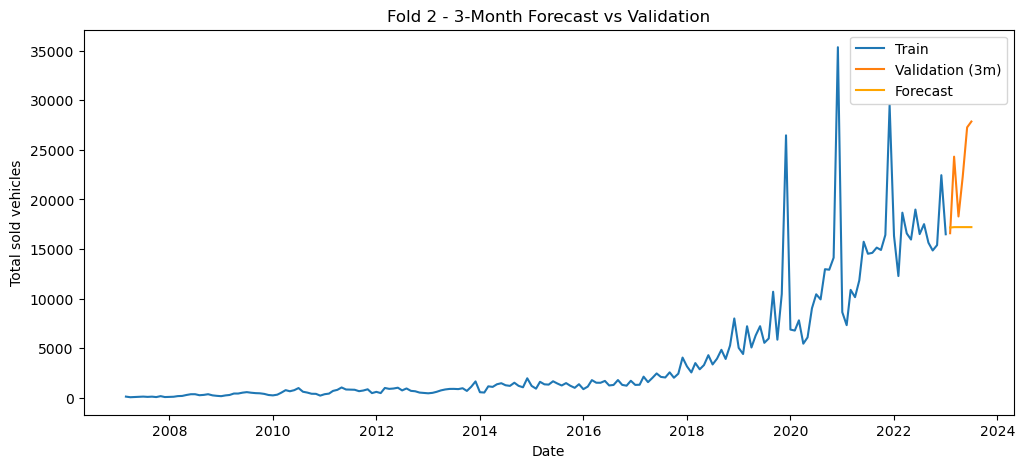


Fold 3
Train: 2007-03-01 to 2024-01-01
Validation: 2024-02-01 to 2024-07-01
RMSE: 3275.07
MAE: 2930.02
MAPE / Error margin (%): 10.92


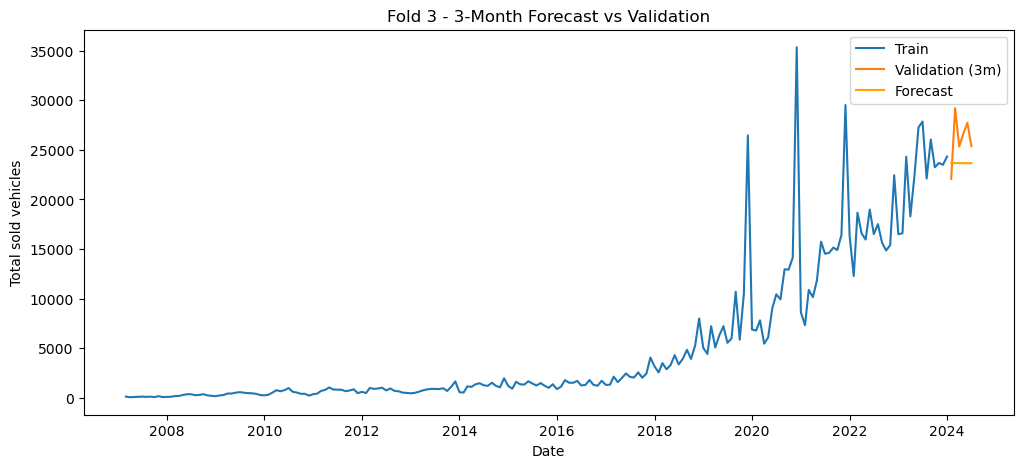


 Average performance over all folds:
Average RMSE: 4187.59
Average MAE: 3496.14
Average MAPE / Error margin (%): 15.31
Average R²: -1.00


In [4]:
# Load data
df = df_lagged.copy()
df['Periode'] = pd.to_datetime(df['Periode'])
df.sort_values('Periode', inplace=True)

# Target only
y = df['Totaal_verkochte_wegvoertuigen']
forecast_horizon = 6
tscv = TimeSeriesSplit(n_splits=3, test_size=12)

# Metrics storage
# Metrics storage
rmse_scores, mae_scores, mape_scores, r2_scores = [], [], [], []


for i, (train_index, val_index) in enumerate(tscv.split(y)):
    y_train, y_val_full = y.iloc[train_index], y.iloc[val_index]
    y_val = y_val_full.iloc[:forecast_horizon]

    # Fit ARIMA model
    model = ARIMA(y_train, order=(1, 1, 1))
    model_fit = model.fit()

    # Forecast
    forecast = model_fit.forecast(steps=forecast_horizon)

    # Metrics
    rmse = np.sqrt(mean_squared_error(y_val, forecast))
    mae = mean_absolute_error(y_val, forecast)
    mape = np.mean(np.abs((y_val - forecast) / y_val)) * 100  # In percentage
    r2 = r2_score(y_val, forecast)

    rmse_scores.append(rmse)
    mae_scores.append(mae)
    mape_scores.append(mape)
    r2_scores.append(r2)


    print(f"\nFold {i+1}")
    print(f"Train: {df.iloc[train_index]['Periode'].min().date()} to {df.iloc[train_index]['Periode'].max().date()}")
    print(f"Validation: {df.iloc[val_index]['Periode'].min().date()} to {(df.iloc[val_index]['Periode'].min() + pd.DateOffset(months=forecast_horizon - 1)).date()}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"MAPE / Error margin (%): {mape:.2f}")

    # Plot
    plt.figure(figsize=(12, 5))
    plt.plot(df.iloc[train_index]['Periode'], y_train, label='Train')
    plt.plot(df.iloc[val_index]['Periode'][:forecast_horizon], y_val, label='Validation (3m)')
    plt.plot(df.iloc[val_index]['Periode'][:forecast_horizon], forecast, label='Forecast', color='orange')
    plt.title(f'Fold {i+1} - 3-Month Forecast vs Validation')
    plt.xlabel('Date')
    plt.ylabel('Total sold vehicles')
    plt.legend()
    plt.show()

# Print averages
print("\n Average performance over all folds:")
print(f"Average RMSE: {np.mean(rmse_scores):.2f}")
print(f"Average MAE: {np.mean(mae_scores):.2f}")
print(f"Average MAPE / Error margin (%): {np.mean(mape_scores):.2f}")
print(f"Average R²: {np.mean(r2_scores):.2f}")


Arima doesnt use feature importance so sarima was used 

#### Seasonal Autoregressive Integrated Moving-Average (SARIMA)
Fitting 3 folds for each of 32 candidates, totalling 96 fits

✅ Best hyperparameters (R²-optimized):
{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}

Best R² score: -0.5280

SARIMA is an extension of ARIMA that is designed to handle time series data with seasonal patterns. It uses the same approach as ARIMA but takes into account seasonal factors that can affect the data. SARIMA is widely used in fields like retail sales and marketing to forecast sales for specific seasons.

https://medium.com/@yennhi95zz/a-guide-to-time-series-models-in-machine-learning-usage-pros-and-cons-ac590a75e8b3


✅ Best SARIMA by R²:
Order: (1, 1, 2)
Seasonal order: (2, 0, 2, 12)
Validation R²: 0.7179

=== Average performance over all folds ===
Average RMSE: 4589.61
Average MAE: 3732.98
Average MAPE: 16.11%
Average R²: -2.1472


Fold 1
Train period: 2007-03-01 → 2022-01-01
Validation period: 2022-02-01 → 2022-07-01
RMSE: 2062.24
MAE: 1940.28
MAPE: 11.87%
R²: 0.1182


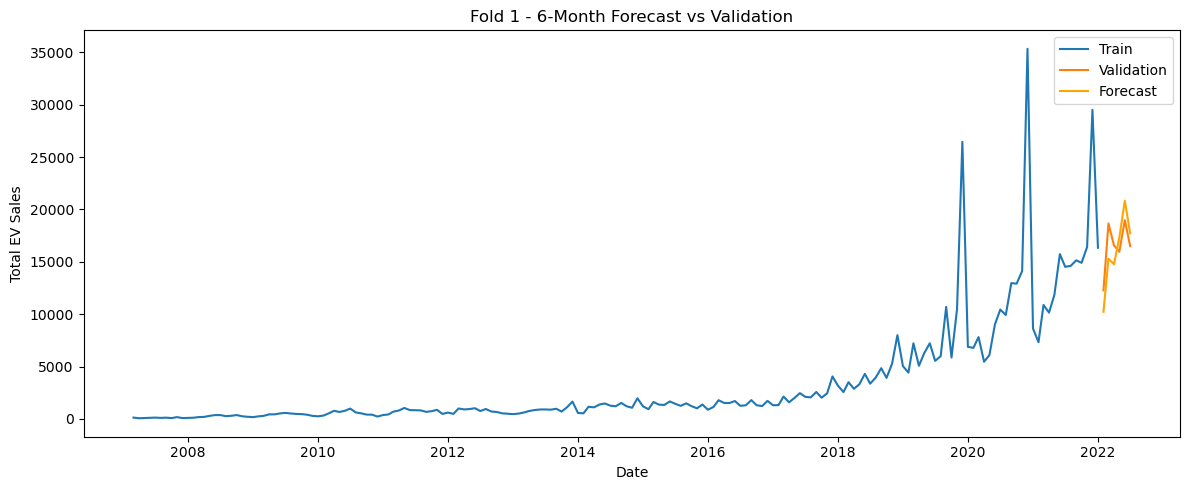


Fold 2
Train period: 2007-03-01 → 2023-01-01
Validation period: 2023-02-01 → 2023-07-01
RMSE: 5994.45
MAE: 4904.27
MAPE: 19.81%
R²: -1.0170


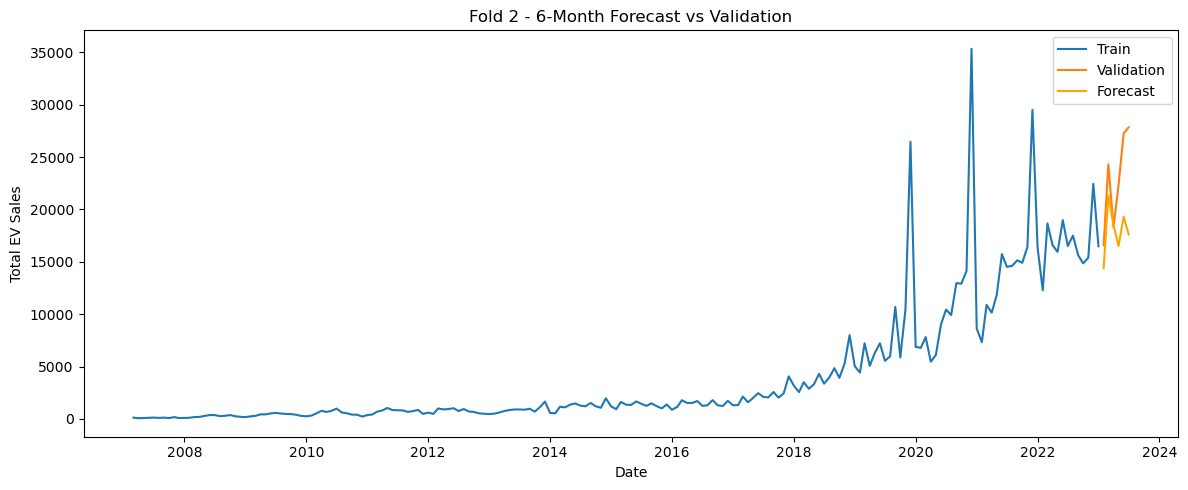


Fold 3
Train period: 2007-03-01 → 2024-01-01
Validation period: 2024-02-01 → 2024-07-01
RMSE: 5712.12
MAE: 4354.37
MAPE: 16.67%
R²: -5.5429


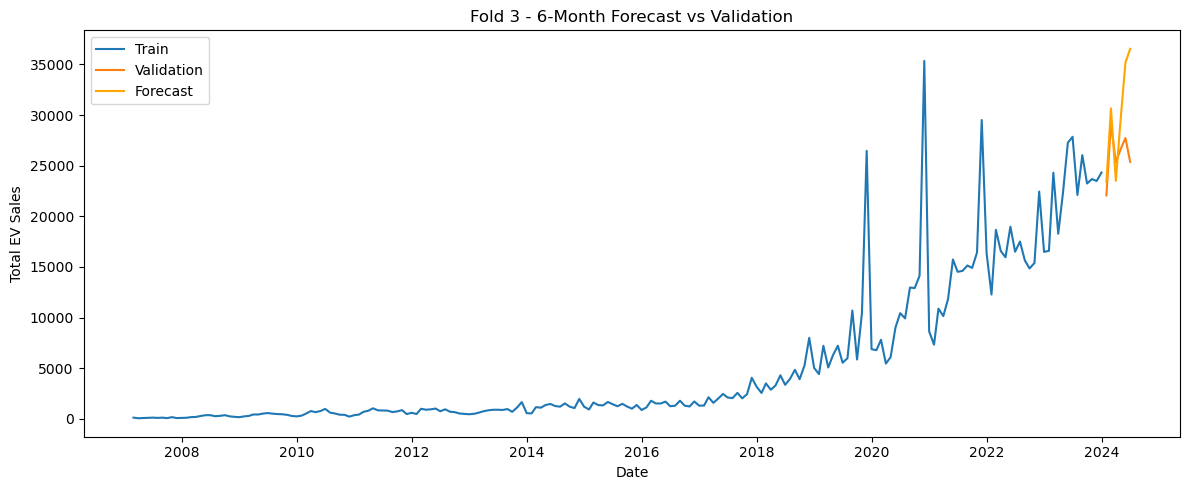


=== Average performance over all folds ===
Average RMSE: 4589.61
Average MAE: 3732.98
Average MAPE: 16.11%
Average R²: -2.1472


In [5]:
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load data
df = df_lagged.copy()
df['Periode'] = pd.to_datetime(df['Periode'])
df.sort_values('Periode', inplace=True)

# Forecast horizon
forecast_horizon = 6
y = df['Totaal_verkochte_wegvoertuigen']
tscv = TimeSeriesSplit(n_splits=3, test_size=12)

# Metrics storage
rmse_scores, mae_scores, mape_scores, r2_scores = [], [], [], []

# SARIMA configuration
p, d, q = 1, 1, 1
P, D, Q, s = 1, 1, 1, 12

# Loop over folds
for i, (train_index, val_index) in enumerate(tscv.split(y)):
    y_train, y_val_full = y.iloc[train_index], y.iloc[val_index]
    y_val = y_val_full.iloc[:forecast_horizon]

    # Fit SARIMA
    model = SARIMAX(y_train, order=(p, d, q), seasonal_order=(P, D, Q, s))
    model_fit = model.fit(disp=0)
    forecast = model_fit.forecast(steps=forecast_horizon)

    # Compute metrics
    rmse = np.sqrt(mean_squared_error(y_val, forecast))
    mae = mean_absolute_error(y_val, forecast)
    mape = np.mean(np.abs((y_val - forecast) / y_val)) * 100
    r2 = r2_score(y_val, forecast)

    # Store metrics
    rmse_scores.append(rmse)
    mae_scores.append(mae)
    mape_scores.append(mape)
    r2_scores.append(r2)

    # Print fold results
    print(f"\nFold {i+1}")
    print(f"Train period: {df.iloc[train_index]['Periode'].min().date()} → {df.iloc[train_index]['Periode'].max().date()}")
    print(f"Validation period: {df.iloc[val_index]['Periode'].min().date()} → {(df.iloc[val_index]['Periode'].min() + pd.DateOffset(months=forecast_horizon - 1)).date()}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"R²: {r2:.4f}")

    # Plot
    plt.figure(figsize=(12, 5))
    plt.plot(df.iloc[train_index]['Periode'], y_train, label='Train')
    plt.plot(df.iloc[val_index]['Periode'][:forecast_horizon], y_val, label='Validation')
    plt.plot(df.iloc[val_index]['Periode'][:forecast_horizon], forecast, label='Forecast', color='orange')
    plt.title(f'Fold {i+1} - {forecast_horizon}-Month Forecast vs Validation')
    plt.xlabel('Date')
    plt.ylabel('Total EV Sales')
    plt.legend()
    plt.tight_layout()
    plt.show()

# --- Final Summary ---
print("\n=== Average performance over all folds ===")
print(f"Average RMSE: {np.mean(rmse_scores):.2f}")
print(f"Average MAE: {np.mean(mae_scores):.2f}")
print(f"Average MAPE: {np.mean(mape_scores):.2f}%")
print(f"Average R²: {np.mean(r2_scores):.4f}")


> Feature importance 


Fold 1
Train period: 2007-03-01 → 2022-01-01
Validation period: 2022-02-01 → 2022-07-01
RMSE: 2062.24
MAE: 1940.28
MAPE: 11.87%
R²: 0.1182


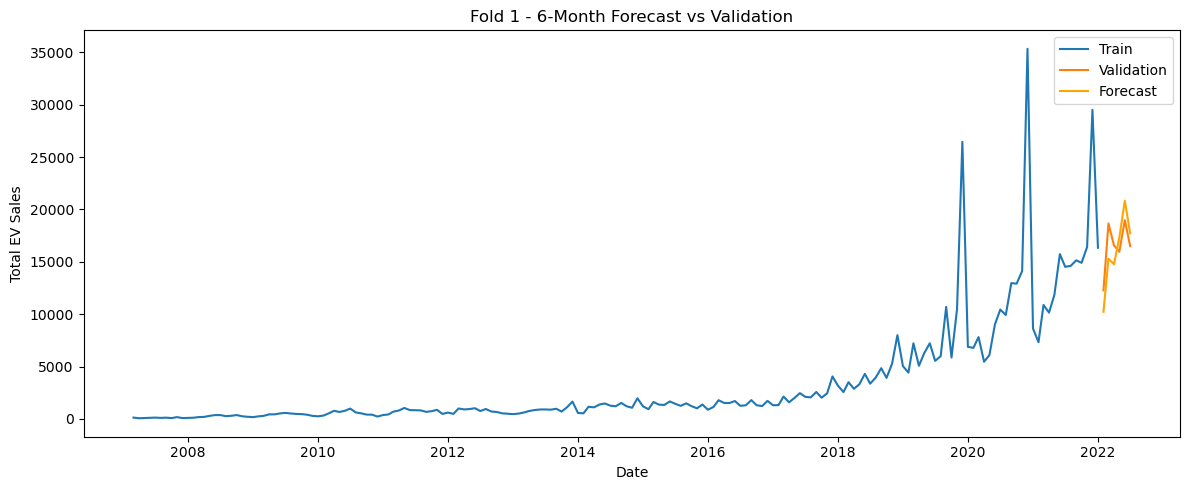


Fold 2
Train period: 2007-03-01 → 2023-01-01
Validation period: 2023-02-01 → 2023-07-01
RMSE: 5994.45
MAE: 4904.27
MAPE: 19.81%
R²: -1.0170


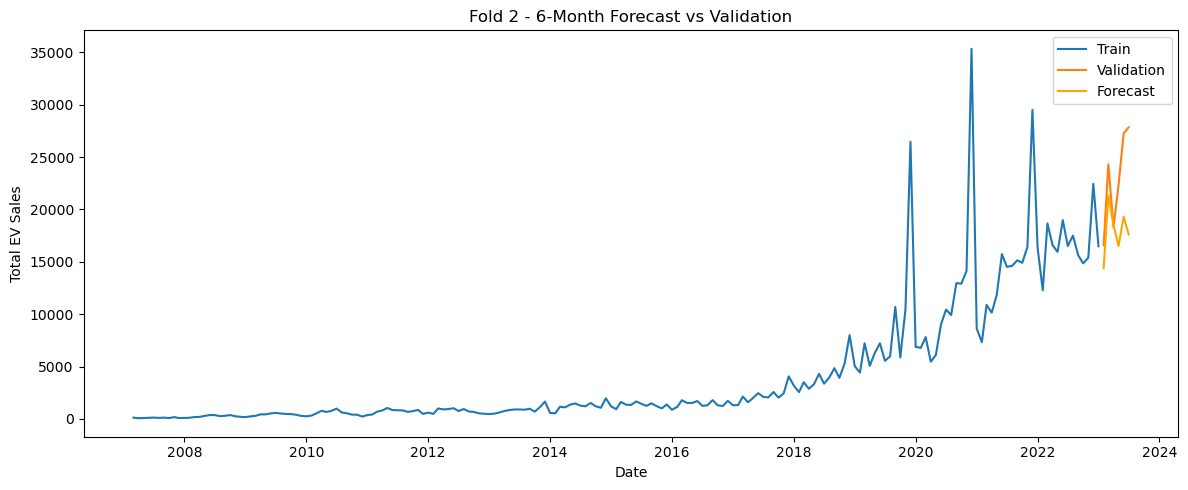


Fold 3
Train period: 2007-03-01 → 2024-01-01
Validation period: 2024-02-01 → 2024-07-01
RMSE: 5712.12
MAE: 4354.37
MAPE: 16.67%
R²: -5.5429


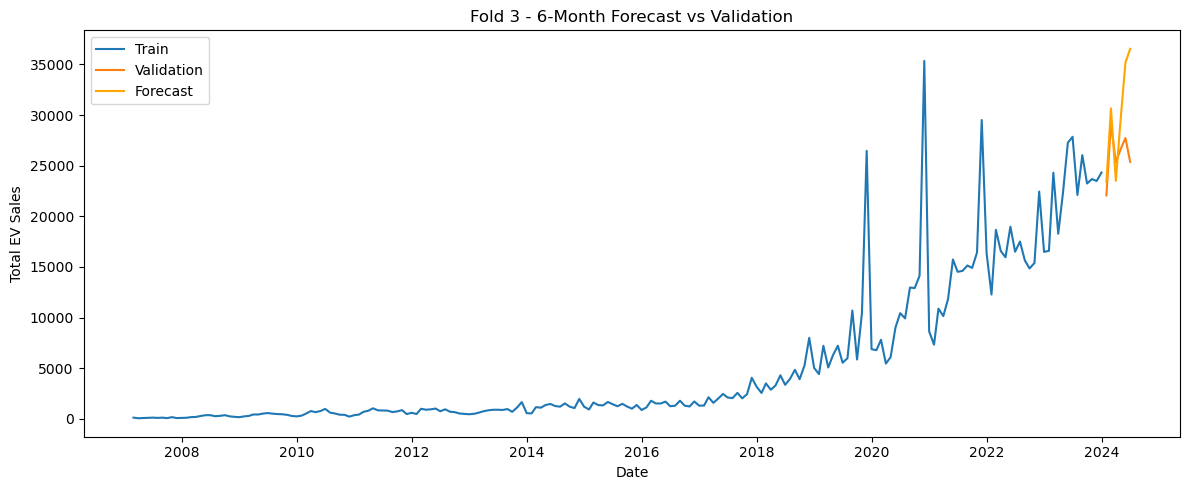


=== Average performance over all folds ===
Average RMSE: 4589.61
Average MAE: 3732.98
Average MAPE: 16.11%
Average R²: -2.1472


In [111]:
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load data
df = df_lagged.copy()
df['Periode'] = pd.to_datetime(df['Periode'])
df.sort_values('Periode', inplace=True)

# Forecast horizon
forecast_horizon = 6
y = df['Totaal_verkochte_wegvoertuigen']
tscv = TimeSeriesSplit(n_splits=3, test_size=12)

# Metrics storage
rmse_scores, mae_scores, mape_scores, r2_scores = [], [], [], []

# SARIMA configuration
p, d, q = 1, 1, 1
P, D, Q, s = 1, 1, 1, 12

# Loop over folds
for i, (train_index, val_index) in enumerate(tscv.split(y)):
    y_train, y_val_full = y.iloc[train_index], y.iloc[val_index]
    y_val = y_val_full.iloc[:forecast_horizon]

    # Fit SARIMA
    model = SARIMAX(y_train, order=(p, d, q), seasonal_order=(P, D, Q, s))
    model_fit = model.fit(disp=0)
    forecast = model_fit.forecast(steps=forecast_horizon)

    # Compute metrics
    rmse = np.sqrt(mean_squared_error(y_val, forecast))
    mae = mean_absolute_error(y_val, forecast)
    mape = np.mean(np.abs((y_val - forecast) / y_val)) * 100
    r2 = r2_score(y_val, forecast)

    # Store metrics
    rmse_scores.append(rmse)
    mae_scores.append(mae)
    mape_scores.append(mape)
    r2_scores.append(r2)

    # Print fold results
    print(f"\nFold {i+1}")
    print(f"Train period: {df.iloc[train_index]['Periode'].min().date()} → {df.iloc[train_index]['Periode'].max().date()}")
    print(f"Validation period: {df.iloc[val_index]['Periode'].min().date()} → {(df.iloc[val_index]['Periode'].min() + pd.DateOffset(months=forecast_horizon - 1)).date()}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"R²: {r2:.4f}")

    # Plot
    plt.figure(figsize=(12, 5))
    plt.plot(df.iloc[train_index]['Periode'], y_train, label='Train')
    plt.plot(df.iloc[val_index]['Periode'][:forecast_horizon], y_val, label='Validation')
    plt.plot(df.iloc[val_index]['Periode'][:forecast_horizon], forecast, label='Forecast', color='orange')
    plt.title(f'Fold {i+1} - {forecast_horizon}-Month Forecast vs Validation')
    plt.xlabel('Date')
    plt.ylabel('Total EV Sales')
    plt.legend()
    plt.tight_layout()
    plt.show()

# --- Final Summary ---
print("\n=== Average performance over all folds ===")
print(f"Average RMSE: {np.mean(rmse_scores):.2f}")
print(f"Average MAE: {np.mean(mae_scores):.2f}")
print(f"Average MAPE: {np.mean(mape_scores):.2f}%")
print(f"Average R²: {np.mean(r2_scores):.4f}")



 LOFO results (sorted by lowest RMSE):
                       Feature_left_out     Avg_RMSE      Avg_MAE  \
18  Totaal_verkochte_wegvoertuigen_lag1  2883.886309  2303.840623   
19  Totaal_verkochte_wegvoertuigen_lag2  3093.893724  2454.319375   
1                      elektrische auto  3198.215756  2637.678115   
6                        Koopbereidheid  3373.330158  2750.367169   
13                       Diesel_2_first  3470.894950  2794.114029   
16                         Diesel_2_max  3496.447759  2870.867202   
15                         Diesel_2_min  3502.865130  2912.884771   
14                        Diesel_2_last  3514.569050  2871.830532   
2                    hybride elektrisch  3525.235322  2878.769751   
17                        Diesel_2_mean  3552.346610  2957.968839   
11                  BenzineEuro95_1_max  3557.189993  2898.178538   
0                         thuis opladen  3592.995438  2974.332409   
7                        Grote aankopen  3612.128475  2957.0194

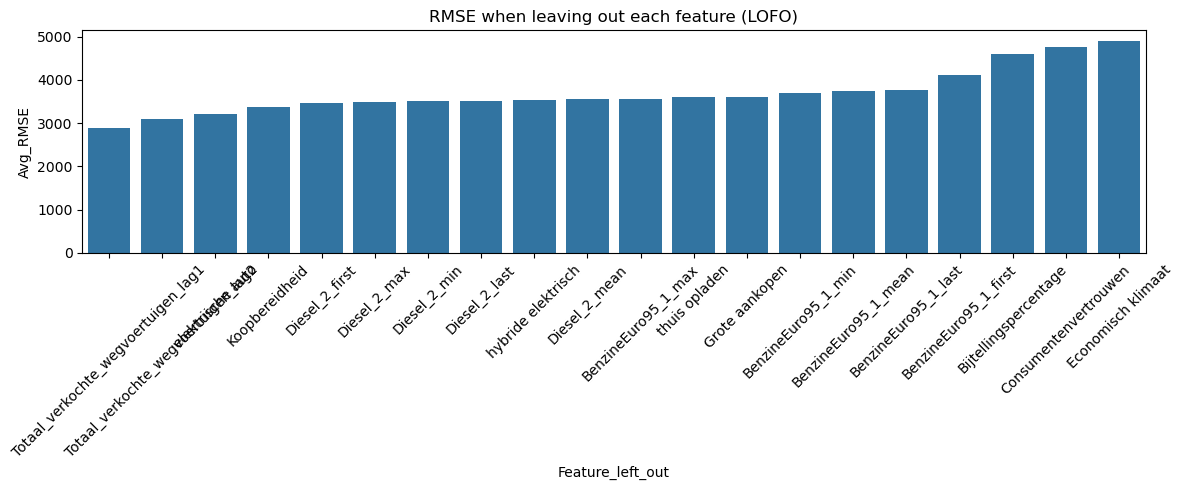

In [7]:
import warnings
warnings.filterwarnings("ignore")
# Prepare data
df = df_lagged.copy()
df['Periode'] = pd.to_datetime(df['Periode'])
df.sort_values('Periode', inplace=True)

target_column = 'Totaal_verkochte_wegvoertuigen'
all_feature_columns = [col for col in df.columns if col not in ['Periode', target_column]]

forecast_horizon = 6
tscv = TimeSeriesSplit(n_splits=3, test_size=12)

results = []

for feature_to_leave_out in all_feature_columns:
    #print(f"\n Evaluating WITHOUT feature: {feature_to_leave_out}")
    feature_columns = [col for col in all_feature_columns if col != feature_to_leave_out]

    X = df[feature_columns]
    y = df[target_column]

    rmse_scores, mae_scores, mape_scores = [], [], []

    for i, (train_index, val_index) in enumerate(tscv.split(y)):
        y_train, y_val_full = y.iloc[train_index], y.iloc[val_index]
        X_train, X_val_full = X.iloc[train_index], X.iloc[val_index]

        y_val = y_val_full.iloc[:forecast_horizon]
        X_val = X_val_full.iloc[:forecast_horizon]

        # Fit SARIMAX
        model = SARIMAX(y_train, exog=X_train, order=(1, 1, 1))
        model_fit = model.fit(disp=False)

        forecast = model_fit.forecast(steps=forecast_horizon, exog=X_val)

        rmse = np.sqrt(mean_squared_error(y_val, forecast))
        mae = mean_absolute_error(y_val, forecast)
        mape = np.mean(np.abs((y_val - forecast) / y_val)) * 100

        rmse_scores.append(rmse)
        mae_scores.append(mae)
        mape_scores.append(mape)

    # Store average results for this feature exclusion
    results.append({
        'Feature_left_out': feature_to_leave_out,
        'Avg_RMSE': np.mean(rmse_scores),
        'Avg_MAE': np.mean(mae_scores),
        'Avg_MAPE (%)': np.mean(mape_scores)
    })

# Show all results in a DataFrame
results_df = pd.DataFrame(results).sort_values('Avg_RMSE')
import seaborn as sns

print("\n LOFO results (sorted by lowest RMSE):")
print(results_df)

# Optional: Plot
plt.figure(figsize=(12, 5))
sns.barplot(data=results_df, x='Feature_left_out', y='Avg_RMSE')
plt.xticks(rotation=45)
plt.title('RMSE when leaving out each feature (LOFO)')
plt.tight_layout()
plt.show()




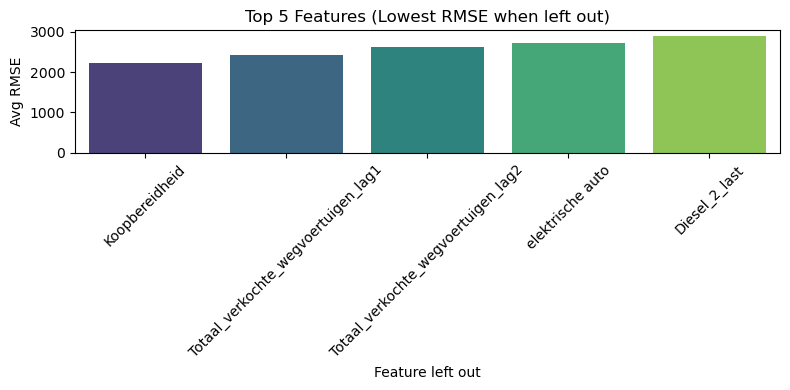

In [7]:
# Plot bar chart for top 5 features (lowest RMSE)
top5 = results_df.head(5)
plt.figure(figsize=(8, 4))
sns.barplot(data=top5, x='Feature_left_out', y='Avg_RMSE', palette='viridis')
plt.title('Top 5 Features (Lowest RMSE when left out)')
plt.ylabel('Avg RMSE')
plt.xlabel('Feature left out')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Gridsearch

In [18]:
import itertools
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

# 1. Define your ranges
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

# 2. Split your series into train/validation
split_index = int(len(y) * 0.85)
y_train, y_val = y.iloc[:split_index], y.iloc[split_index:]

# 3. Track the best model by R²
best_r2 = -np.inf
best_order = None
best_seasonal_order = None

for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            model = SARIMAX(y_train, order=param, seasonal_order=seasonal_param)
            results = model.fit(disp=False)
            forecast = results.forecast(steps=len(y_val))
            r2 = r2_score(y_val, forecast)

            if r2 > best_r2:
                best_r2 = r2
                best_order = param
                best_seasonal_order = seasonal_param

        except:
            continue

print(f"✅ Best SARIMA by R²:")
print(f"Order: {best_order}")
print(f"Seasonal order: {best_seasonal_order}")
print(f"Validation R²: {best_r2:.4f}")


✅ Best SARIMA by R²:
Order: (1, 1, 2)
Seasonal order: (2, 0, 2, 12)
Validation R²: 0.7179


Als je wil weten of features als Bijtelling, Koopbereidheid, of elektrische auto-zoektermen extra waarde toevoegen:

In [19]:
exog_train = X.iloc[:split_index]   # je exogene features
exog_val = X.iloc[split_index:]

model = SARIMAX(y_train, exog=exog_train, order=(1, 1, 2), seasonal_order=(2, 0, 2, 12))
results = model.fit(disp=False)
forecast = results.forecast(steps=len(y_val), exog=exog_val)
r2_score(y_val, forecast)



-1.7155044055170885

In [9]:
warnings.filterwarnings("ignore")

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]  # s = 12 for monthly data

best_aic = float('inf')
best_order = None
best_seasonal_order = None

for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            model = SARIMAX(y_train, order=param, seasonal_order=seasonal_param)
            results = model.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = param
                best_seasonal_order = seasonal_param
        except:
            continue

print(f"Best SARIMA: order={best_order}, seasonal_order={best_seasonal_order}, AIC={best_aic}")


Best SARIMA: order=(2, 1, 1), seasonal_order=(2, 0, 0, 12), AIC=-640.302361371634


In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings("ignore")

# 1. Load and prepare your data
df = df_lagged.copy()
df['Periode'] = pd.to_datetime(df['Periode'])
df.sort_values('Periode', inplace=True)

X = df.drop(columns=['Periode', 'Totaal_verkochte_wegvoertuigen'])
y = df['Totaal_verkochte_wegvoertuigen']

# 2. Define time series cross-validation
tscv = TimeSeriesSplit(n_splits=3)

# 3. XGBoost model and parameter grid
xgb = XGBRegressor(objective='reg:squarederror', verbosity=0)

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# 4. GridSearchCV to optimize for R²
grid_search_r2 = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='r2',
    cv=tscv,
    verbose=1,
    n_jobs=-1
)

# 5. Train model
grid_search_r2.fit(X, y)

# 6. Output results
print("\n✅ Best hyperparameters (R²-optimized):")
print(grid_search_r2.best_params_)

print(f"\nBest R² score: {grid_search_r2.best_score_:.4f}")


Fitting 3 folds for each of 32 candidates, totalling 96 fits

✅ Best hyperparameters (R²-optimized):
{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}

Best R² score: -0.5280


#### LSTM (Long Short-Term Memory)

no gridsearch yet: 

🔚 Average performance over all folds:
Average RMSE: 5262.84
Average MAE: 4533.36
Average MAPE / Error margin (%): 18.29
Average R²: -4.9191

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step

Fold 1
RMSE: 2825.29
MAE: 2425.75
MAPE / Error margin (%): 15.44
R²: -0.2227


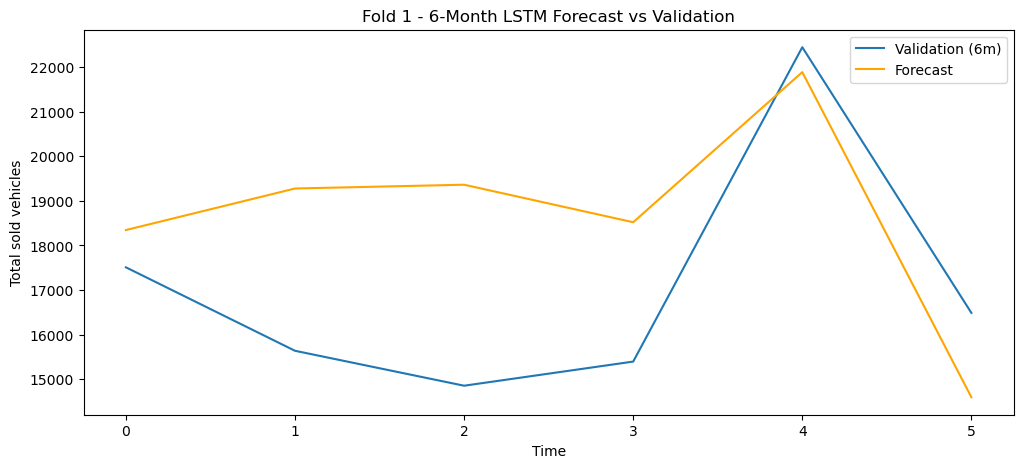

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step

Fold 2
RMSE: 7258.60
MAE: 6240.70
MAPE / Error margin (%): 25.53
R²: -1.9574


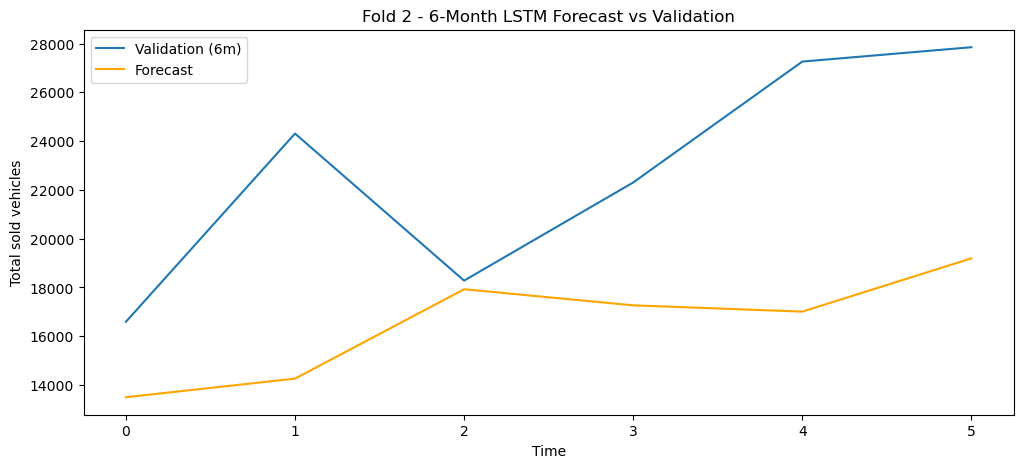

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step

Fold 3
RMSE: 3729.92
MAE: 3013.57
MAPE / Error margin (%): 12.73
R²: -8.7326


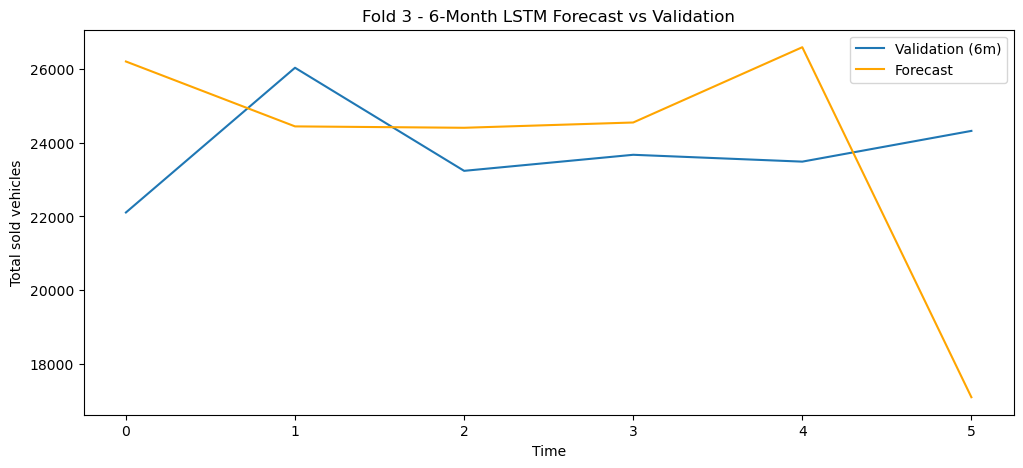

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step

Fold 4
RMSE: 7075.54
MAE: 6670.78
MAPE / Error margin (%): 25.30
R²: -9.0391


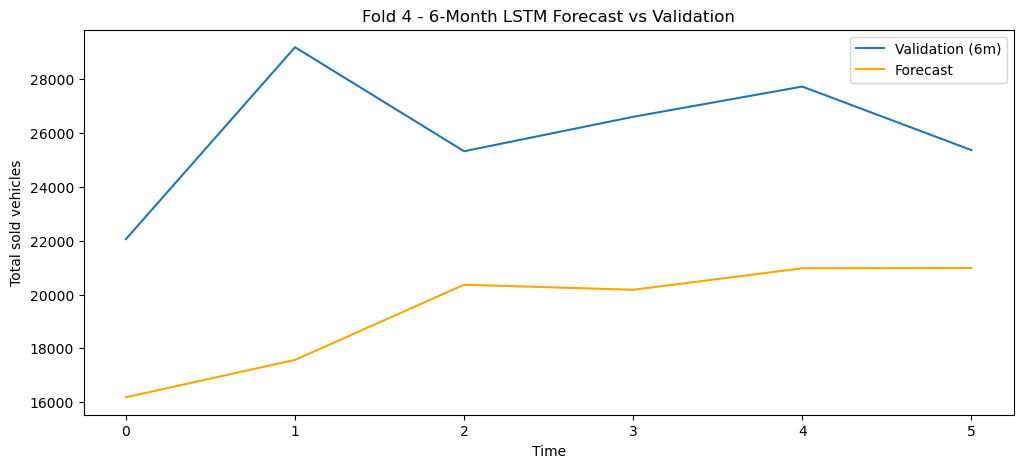

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step

Fold 5
RMSE: 5190.03
MAE: 4415.20
MAPE / Error margin (%): 13.19
R²: -0.1476


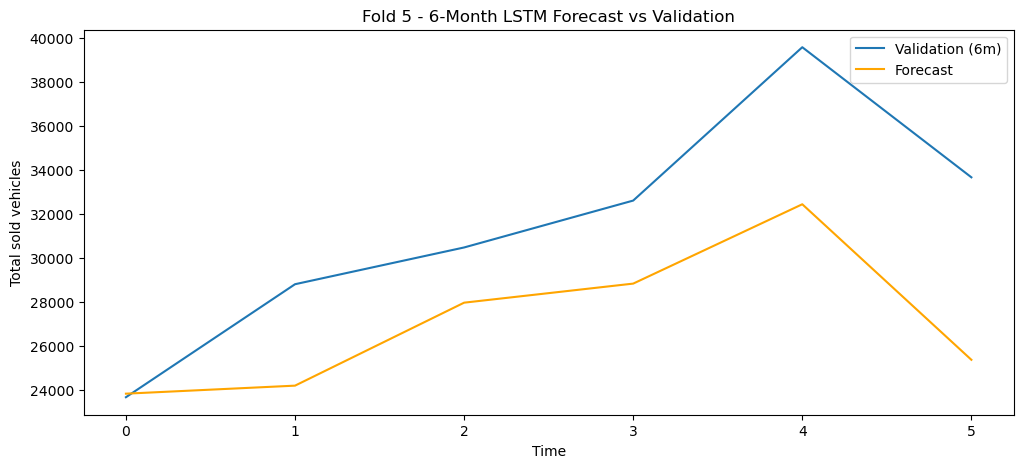


🔚 Average performance over all folds:
Average RMSE: 5215.88
Average MAE: 4553.20
Average MAPE / Error margin (%): 18.44
Average R²: -4.0199


In [36]:
# Prepare data
df = df_lagged.copy()
df['Periode'] = pd.to_datetime(df['Periode'])
df.sort_values('Periode', inplace=True)

feature_cols = [col for col in df.columns if col not in ['Periode', 'Totaal_verkochte_wegvoertuigen']]
X = df[feature_cols].values
y = df['Totaal_verkochte_wegvoertuigen'].values.reshape(-1, 1)
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
X_scaled = X_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y)
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

forecast_horizon = 6
tscv = TimeSeriesSplit(n_splits=5, test_size=6)

rmse_scores, mae_scores, mape_scores, r2_scores = [], [], [], []

for i, (train_index, val_index) in enumerate(tscv.split(X_scaled)):
    X_train, X_val_full = X_scaled[train_index], X_scaled[val_index]
    y_train, y_val_full = y_scaled[train_index], y_scaled[val_index]
    X_val, y_val = X_val_full[:forecast_horizon], y_val_full[:forecast_horizon]

    model = Sequential([
        LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=50, batch_size=8, verbose=0)

    y_pred = model.predict(X_val)
    y_pred_inv = y_scaler.inverse_transform(y_pred)
    y_val_inv = y_scaler.inverse_transform(y_val)

    rmse = np.sqrt(np.mean((y_val_inv - y_pred_inv) ** 2))
    mae = np.mean(np.abs(y_val_inv - y_pred_inv))
    mape = np.mean(np.abs((y_val_inv - y_pred_inv) / y_val_inv)) * 100
    r2 = r2_score(y_val_inv, y_pred_inv)

    rmse_scores.append(rmse)
    mae_scores.append(mae)
    mape_scores.append(mape)
    r2_scores.append(r2)

    print(f"\nFold {i+1}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"MAPE / Error margin (%): {mape:.2f}")
    print(f"R²: {r2:.4f}")

    plt.figure(figsize=(12, 5))
    plt.plot(range(len(y_val_inv)), y_val_inv, label='Validation (6m)')
    plt.plot(range(len(y_pred_inv)), y_pred_inv, label='Forecast', color='orange')
    plt.title(f'Fold {i+1} - 6-Month LSTM Forecast vs Validation')
    plt.xlabel('Time')
    plt.ylabel('Total sold vehicles')
    plt.legend()
    plt.show()

print("\n🔚 Average performance over all folds:")
print(f"Average RMSE: {np.mean(rmse_scores):.2f}")
print(f"Average MAE: {np.mean(mae_scores):.2f}")
print(f"Average MAPE / Error margin (%): {np.mean(mape_scores):.2f}")
print(f"Average R²: {np.mean(r2_scores):.4f}")


In [35]:
%pip install --upgrade scikit-learn scikeras

from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV

# Define a function to build the LSTM model (for KerasRegressor)
def build_lstm(units=32, learning_rate=0.001):
    model = Sequential([
        LSTM(units, input_shape=(X_scaled.shape[1], X_scaled.shape[2])),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Wrap the model for scikit-learn using SciKeras
reg = KerasRegressor(model=build_lstm, epochs=50, batch_size=8, verbose=0)

# Define parameter grid
param_grid = {
    'model__units': [16, 32, 64],
    'epochs': [30, 50],
    'batch_size': [8, 16]
}

# Use TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=3)

# GridSearchCV for best R²
grid = GridSearchCV(estimator=reg, param_grid=param_grid, scoring='r2', cv=tscv)
grid.fit(X_scaled, y_scaled)

print("Best hyperparameters (R²):")
print(grid.best_params_)
print(f"Best R² score: {grid.best_score_:.4f}")


Note: you may need to restart the kernel to use updated packages.


AttributeError: 'super' object has no attribute '__sklearn_tags__'

#### xgboost
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best hyperparameters (R²):
{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 10, 'reg_lambda': 1, 'subsample': 1.0}
Best R² score: -0.9632

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb

# --- Laad en bereid de data voor ---
df = df_lagged.copy()
df['Periode'] = pd.to_datetime(df['Periode'])
df.sort_values('Periode', inplace=True)

X = df.drop(columns=['Totaal_verkochte_wegvoertuigen', 'Periode'])
y = df['Totaal_verkochte_wegvoertuigen']

# --- TimeSeriesSplit instellingen ---
tscv = TimeSeriesSplit(n_splits=5, test_size=6)

# --- Opslag evaluatiestatistieken ---
mae_scores = []
rmse_scores = []
r2_scores = []
mape_scores = []
mapa_scores = []

# --- Cross-validation loop ---
for i, (train_idx, test_idx) in enumerate(tscv.split(X)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=500,
        max_depth=3,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=10,
        reg_lambda=1,
        random_state=42,
        eval_metric='mae'
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # --- Evaluatie ---
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    mapa = np.mean(np.arctan(np.abs((y_test - y_pred) / y_test))) * (100 / (np.pi / 2))

    mae_scores.append(mae)
    rmse_scores.append(rmse)
    r2_scores.append(r2)
    mape_scores.append(mape)
    mapa_scores.append(mapa)

    print(f"\nFold {i+1}")
    print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}, MAPE: {mape:.2f}%, MAPA: {mapa:.2f}%")

# --- Gemiddelde resultaten over alle folds ---
print("\n=== Gemiddelde prestaties over alle folds ===")
print(f"Average MAE:  {np.mean(mae_scores):.2f}")
print(f"Average RMSE: {np.mean(rmse_scores):.2f}")
print(f"Average R²:   {np.mean(r2_scores):.4f}")
print(f"Average MAPE: {np.mean(mape_scores):.2f}%")
print(f"Average MAPA: {np.mean(mapa_scores):.2f}%")



Fold 1
MAE: 2381.81, RMSE: 3349.16, R²: -0.7182, MAPE: 12.69%, MAPA: 7.94%

Fold 2
MAE: 8365.79, RMSE: 9126.61, R²: -3.6755, MAPE: 35.15%, MAPA: 21.34%

Fold 3
MAE: 3369.43, RMSE: 4020.90, R²: -10.3104, MAPE: 13.82%, MAPA: 8.68%

Fold 4
MAE: 5327.68, RMSE: 5652.51, R²: -5.4070, MAPE: 20.03%, MAPA: 12.54%

Fold 5
MAE: 7199.31, RMSE: 8398.49, R²: -2.0051, MAPE: 21.38%, MAPA: 13.26%

=== Gemiddelde prestaties over alle folds ===
Average MAE:  5328.81
Average RMSE: 6109.53
Average R²:   -4.4232
Average MAPE: 20.61%
Average MAPA: 12.75%


In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import itertools

# --- Load data ---
df = df_lagged.copy()
df['Periode'] = pd.to_datetime(df['Periode'])
df.sort_values('Periode', inplace=True)

X = df.drop(columns=['Totaal_verkochte_wegvoertuigen', 'Periode'])
y = df['Totaal_verkochte_wegvoertuigen']

# --- Cross-validation setup ---
tscv = TimeSeriesSplit(n_splits=5, test_size=6)

# --- Parameter grid (compact but flexible) ---
param_grid = {
    'n_estimators': [100, 250],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'reg_alpha': [0, 10],
    'reg_lambda': [1]
}
param_combinations = list(itertools.product(
    param_grid['n_estimators'],
    param_grid['max_depth'],
    param_grid['learning_rate'],
    param_grid['subsample'],
    param_grid['colsample_bytree'],
    param_grid['reg_alpha'],
    param_grid['reg_lambda']
))

# --- Metric storage ---
mae_scores, rmse_scores, r2_scores, mape_scores, mapa_scores = [], [], [], [], []

# --- TimeSeries Cross-Validation loop with manual grid search ---
for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

    best_r2 = -np.inf
    best_model = None

    # Grid search over hyperparameters
    for params in param_combinations:
        model = xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=params[0],
            max_depth=params[1],
            learning_rate=params[2],
            subsample=params[3],
            colsample_bytree=params[4],
            reg_alpha=params[5],
            reg_lambda=params[6],
            random_state=42,
            eval_metric='mae'
        )
        model.fit(X_train, y_train)
        y_val_pred = model.predict(X_val)
        r2 = r2_score(y_val, y_val_pred)

        if r2 > best_r2:
            best_r2 = r2
            best_model = model
            best_pred = y_val_pred

    # Final evaluation with best model on this fold
    mae = mean_absolute_error(y_val, best_pred)
    rmse = np.sqrt(mean_squared_error(y_val, best_pred))
    mape = np.mean(np.abs((y_val - best_pred) / y_val)) * 100
    mapa = np.mean(np.arctan(np.abs((y_val - best_pred) / y_val))) * (100 / (np.pi / 2))

    mae_scores.append(mae)
    rmse_scores.append(rmse)
    r2_scores.append(best_r2)
    mape_scores.append(mape)
    mapa_scores.append(mapa)

    print(f"\nFold {fold+1} — Best R²: {best_r2:.4f}")
    print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2f}%, MAPA: {mapa:.2f}%")

# --- Summary of all folds ---
print("\n=== Average Metrics Over All Folds ===")
print(f"Average MAE:   {np.mean(mae_scores):.2f}")
print(f"Average RMSE:  {np.mean(rmse_scores):.2f}")
print(f"Average R²:    {np.mean(r2_scores):.4f}")
print(f"Average MAPE:  {np.mean(mape_scores):.2f}%")
print(f"Average MAPA:  {np.mean(mapa_scores):.2f}%")



Fold 1 — Best R²: 0.1754
MAE: 2020.63, RMSE: 2320.22, MAPE: 12.44%, MAPA: 7.83%

Fold 2 — Best R²: -2.6216
MAE: 7005.64, RMSE: 8032.47, MAPE: 29.38%, MAPA: 17.95%

Fold 3 — Best R²: -19.0476
MAE: 4940.66, RMSE: 5353.23, MAPE: 20.60%, MAPA: 12.85%

Fold 4 — Best R²: -12.7870
MAE: 7898.48, RMSE: 8291.78, MAPE: 29.76%, MAPA: 18.31%

Fold 5 — Best R²: -3.4809
MAE: 8625.48, RMSE: 10255.49, MAPE: 25.34%, MAPA: 15.54%

=== Average Metrics Over All Folds ===
Average MAE:   6098.18
Average RMSE:  6850.64
Average R²:    -7.5524
Average MAPE:  23.51%
Average MAPA:  14.50%


In [25]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from xgboost import XGBRegressor

# Prepare data (exog_train and y_train are already defined)
# Ensure y_train is aligned with exog_train
X = exog_train
y = y_train.loc[exog_train.index]

# Define parameter grid
param_grid = {
    'n_estimators': [100, 250],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 10],
    'reg_lambda': [1]
}

# TimeSeriesSplit for time series data
tscv = TimeSeriesSplit(n_splits=5)

# XGBoost regressor
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

# GridSearchCV for best R²
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='r2',
    cv=tscv,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X, y)

print("Best hyperparameters (R²):")
print(grid_search.best_params_)
print(f"Best R² score: {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best hyperparameters (R²):
{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 10, 'reg_lambda': 1, 'subsample': 1.0}
Best R² score: -0.9632


In [26]:
print([col for col in X.columns if 'lag' in col.lower()])


['Totaal_verkochte_wegvoertuigen_lag1', 'Totaal_verkochte_wegvoertuigen_lag2']


 #### SARIMAX-code met exogene variabelen  
=== Gemiddelde prestaties SARIMAX ===
Average RMSE: 4776.29
Average MAE: 4161.23
Average R²: -1.5153
Average MAPE: 18.37%



Fold 1
R²: -0.2034, RMSE: 2409.14, MAE: 2100.60, MAPE: 12.64%


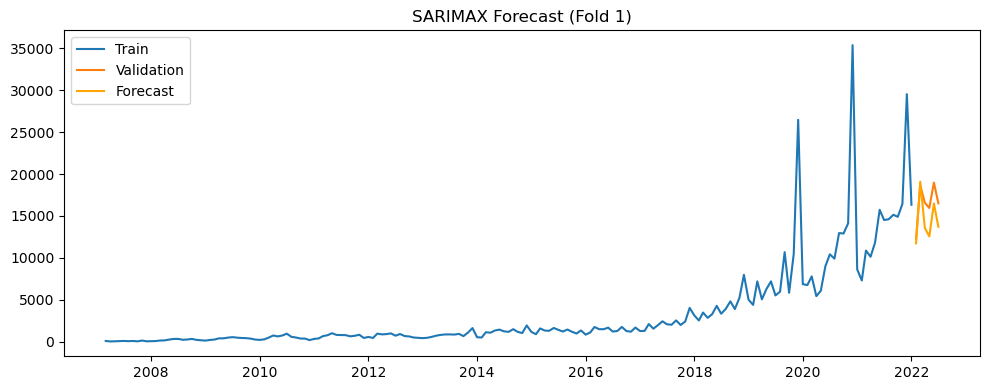


Fold 2
R²: -4.5822, RMSE: 9972.40, MAE: 8937.84, MAPE: 36.83%


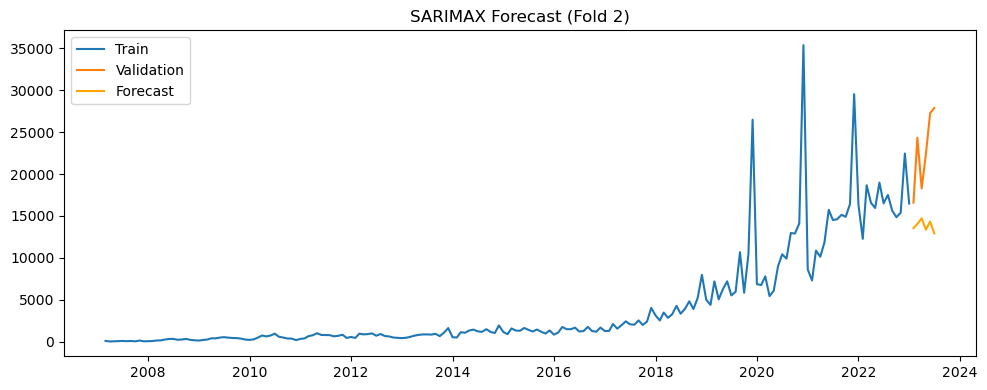


Fold 3
R²: 0.2396, RMSE: 1947.34, MAE: 1445.25, MAPE: 5.64%


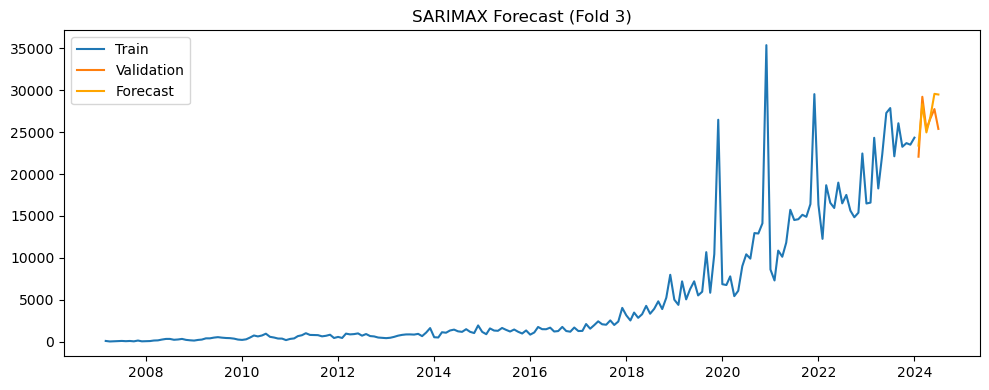


=== Gemiddelde prestaties SARIMAX ===
Average RMSE: 4776.29
Average MAE: 4161.23
Average R²: -1.5153
Average MAPE: 18.37%


In [29]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

# --- Laad data ---
df = df_lagged.copy()
df['Periode'] = pd.to_datetime(df['Periode'])
df.sort_values('Periode', inplace=True)

# --- Targets en exogene variabelen definiëren ---
y = df['Totaal_verkochte_wegvoertuigen']

# Kies je exogene variabelen hier:
exog_features = [
    'Bijtellingspercentage',
    'Koopbereidheid',
    'elektrische auto',  # Google Trends
    # Voeg hier meer variabelen toe indien gewenst
]
X = df[exog_features]

# --- TimeSeriesSplit instellen ---
tscv = TimeSeriesSplit(n_splits=3, test_size=12)
forecast_horizon = 6

# --- Opslag evaluatiemetrics ---
rmse_scores, mae_scores, r2_scores, mape_scores = [], [], [], []

# --- SARIMAX configuratie ---
order = (1, 1, 2)
seasonal_order = (2, 0, 2, 12)

# --- Loop over folds ---
for i, (train_idx, val_idx) in enumerate(tscv.split(y)):
    y_train, y_val_full = y.iloc[train_idx], y.iloc[val_idx]
    X_train, X_val_full = X.iloc[train_idx], X.iloc[val_idx]
    
    y_val = y_val_full.iloc[:forecast_horizon]
    X_val = X_val_full.iloc[:forecast_horizon]

    # Fit model
    model = SARIMAX(
        endog=y_train,
        exog=X_train,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    model_fit = model.fit(disp=False)

    # Forecast
    forecast = model_fit.forecast(steps=forecast_horizon, exog=X_val)

    # Metrics
    mae = mean_absolute_error(y_val, forecast)
    rmse = np.sqrt(mean_squared_error(y_val, forecast))
    r2 = r2_score(y_val, forecast)
    mape = np.mean(np.abs((y_val - forecast) / y_val)) * 100

    mae_scores.append(mae)
    rmse_scores.append(rmse)
    r2_scores.append(r2)
    mape_scores.append(mape)

    print(f"\nFold {i+1}")
    print(f"R²: {r2:.4f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}, MAPE: {mape:.2f}%")

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(df.iloc[train_idx]['Periode'], y_train, label='Train')
    plt.plot(df.iloc[val_idx]['Periode'][:forecast_horizon], y_val, label='Validation')
    plt.plot(df.iloc[val_idx]['Periode'][:forecast_horizon], forecast, label='Forecast', color='orange')
    plt.title(f'SARIMAX Forecast (Fold {i+1})')
    plt.legend()
    plt.tight_layout()
    plt.show()

# --- Gemiddelde prestaties ---
print("\n=== Gemiddelde prestaties SARIMAX ===")
print(f"Average RMSE: {np.mean(rmse_scores):.2f}")
print(f"Average MAE: {np.mean(mae_scores):.2f}")
print(f"Average R²: {np.mean(r2_scores):.4f}")
print(f"Average MAPE: {np.mean(mape_scores):.2f}%")


In [30]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from xgboost import XGBRegressor

# Use exog_train and y_train (already defined)
X = exog_train
y = y_train.loc[exog_train.index]

# Use the param_grid you already have
tscv = TimeSeriesSplit(n_splits=5)

xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='r2',
    cv=tscv,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X, y)

print("Best hyperparameters (R²):")
print(grid_search.best_params_)
print(f"Best R² score: {grid_search.best_score_:.4f}")


Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best hyperparameters (R²):
{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 10, 'reg_lambda': 1, 'subsample': 1.0}
Best R² score: -0.9632


#### Temporal Fusion Transformer (TFT)

In [104]:
from pytorch_forecasting.metrics import MAE
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Predict the next 6 months using the trained TFT model
# (Assume 'tft' is your trained TemporalFusionTransformer model)
# Use the validation dataloader for prediction
raw_predictions, x = tft.predict(val_dataloader, mode="raw", return_x=True)

# Extract predictions and true values for the first (and only) sequence in the validation set
# Each prediction is shape (batch, prediction_length)
y_pred = raw_predictions[0].detach().cpu().numpy().flatten()
y_true = x['decoder_target'][0].detach().cpu().numpy().flatten()

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print("TFT 6-month validation forecast:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE:  {mae:.2f}")
print(f"R²:   {r2:.4f}")

NameError: name 'tft' is not defined

In [105]:
%pip install lightning pytorch-forecasting
%pip install pytorch_optimizer

import copy
from pathlib import Path
import warnings

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np
import pandas as pd
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import (
    optimize_hyperparameters,
)

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Load data

c:\Users\dylan\anaconda3\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\dylan\anaconda3\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                               | Type                            | Params | Mode 
---------------------------------------------------------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\dylan\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\dylan\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\dylan\anaconda3\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\dylan\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.



=== 📈 Forecast Evaluation over Last 6 Months ===
MAE:  7017.87
RMSE: 8099.60
R²:   -1.7950
MAPE: 20.87%


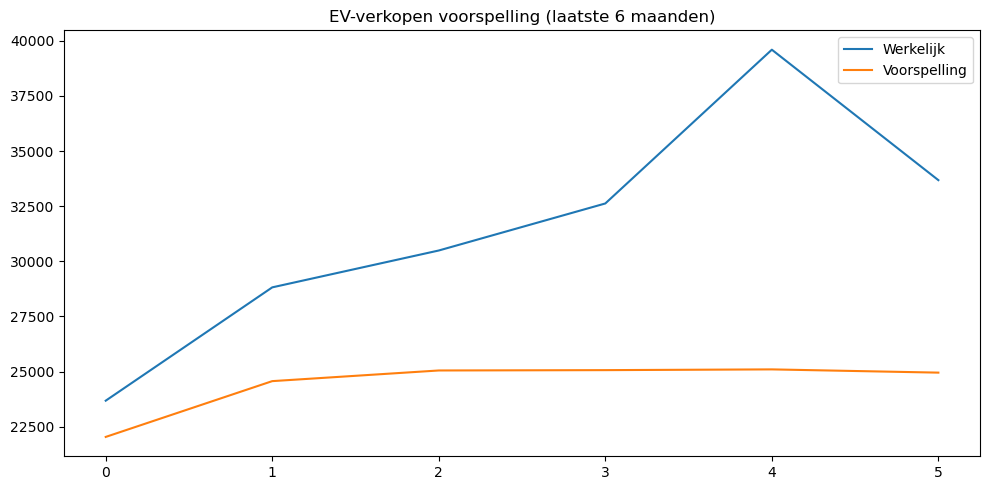

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet, GroupNormalizer
from pytorch_forecasting.metrics import MAE, RMSE
from lightning.pytorch import Trainer
from pytorch_forecasting.data import NaNLabelEncoder
from torch.utils.data import DataLoader
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# === 1. Data voorbereiden ===
df = df_lagged.copy()
df["Periode"] = pd.to_datetime(df["Periode"])
df = df.sort_values("Periode")
df["time_idx"] = (df["Periode"].dt.year - df["Periode"].dt.year.min()) * 12 + df["Periode"].dt.month
df["groep"] = "EV"  # alles is 1 groep

# Config
target = "Totaal_verkochte_wegvoertuigen"
known_reals = ["Bijtellingspercentage", "elektrische auto", "Consumentenvertrouwen"]
max_encoder_length = 24
max_prediction_length = 6
training_cutoff = df["time_idx"].max() - max_prediction_length

# === 2. Dataset maken ===
training = TimeSeriesDataSet(
    df[df.time_idx <= training_cutoff],
    time_idx="time_idx",
    target=target,
    group_ids=["groep"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    time_varying_known_reals=known_reals + ["time_idx"],
    time_varying_unknown_reals=[target],
    target_normalizer=GroupNormalizer(groups=["groep"], transformation="softplus"),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

validation = TimeSeriesDataSet.from_dataset(training, df, predict=True, stop_randomization=True)
train_loader = training.to_dataloader(train=True, batch_size=32)
val_loader = validation.to_dataloader(train=False, batch_size=32)

# === 3. Model trainen ===
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    loss=MAE(),
    log_interval=10,
    log_val_interval=1,
    reduce_on_plateau_patience=4,
)

trainer = Trainer(max_epochs=30, accelerator="cpu")
trainer.fit(tft, train_dataloaders=train_loader, val_dataloaders=val_loader)

# === 4. Voorspellen & evalueren ===
pred_series = tft.predict(val_loader)
actuals = torch.cat([y[0] for x, y in iter(val_loader)]).numpy()

# Alleen de laatste 6 maanden
y_pred = pred_series[:, -max_prediction_length:].flatten().numpy()
y_true = actuals[:, -max_prediction_length:].flatten()

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print("\n=== 📈 Forecast Evaluation over Last 6 Months ===")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.4f}")
print(f"MAPE: {mape:.2f}%")

# === 5. Plot voorspelling vs. echt ===
plt.figure(figsize=(10, 5))
plt.plot(y_true, label="Werkelijk")
plt.plot(y_pred, label="Voorspelling")
plt.title("EV-verkopen voorspelling (laatste 6 maanden)")
plt.legend()
plt.tight_layout()
plt.show()


In [8]:
# Assume df_lagged is already loaded and contains your data

# Add time index (monthly, starting from 0)
df_lagged = df_lagged.copy()
df_lagged['Periode'] = pd.to_datetime(df_lagged['Periode'])
df_lagged = df_lagged.sort_values('Periode')
df_lagged['time_idx'] = (df_lagged['Periode'].dt.year * 12 + df_lagged['Periode'].dt.month)
df_lagged['time_idx'] -= df_lagged['time_idx'].min()

# Add month as categorical
df_lagged['month'] = df_lagged['Periode'].dt.month.astype(str).astype('category')

# Example: add log of target (optional)
df_lagged['log_sales'] = np.log(df_lagged['Totaal_verkochte_wegvoertuigen'] + 1e-8)

# Show a sample
df_lagged.sample(10, random_state=521)


Periode  thuis opladen  elektrische auto  hybride elektrisch  \
127 2017-10-01             25                19                   0   
16  2008-07-01              0                 2                   0   
99  2015-06-01             19                12                   0   
203 2024-02-01             54                49                  48   
0   2007-03-01              0                 0                   0   
23  2009-02-01              0                 3                   0   
66  2012-09-01             21                12                   0   
61  2012-04-01              0                14                   0   
37  2010-04-01              0                 6                   0   
160 2020-07-01             68                39                  23   

     Bijtellingspercentage  Consumentenvertrouwen  Economisch klimaat  \
127                      4                   22.5                42.5   
16                       0                  -17.8               -35.4   
99                       4                   10.4                29.2   
203                     16                  -25.0               -37.5   
0                        0                   20.0                37.0   
23                       0                  -26.0               -54.0   
66                       0                  -28.0               -40.0   
61                       0                  -32.0               -51.0   
37                       0                   -7.0                -7.0   
160                      8                  -26.0               -47.2   

     Koopbereidheid  Grote aankopen  BenzineEuro95_1_first  ...  \
127            10.0            19.0                  1.538  ...   
16             -6.0           -14.2                  1.633  ...   
99             -2.4            -0.4                  1.638  ...   
203           -17.0           -36.5                  1.944  ...   
0               9.0             8.0                  1.365  ...   
23             -7.5           -18.5                  1.264  ...   
66            -20.0           -24.0                  1.809  ...   
61            -19.0           -22.0                  1.810  ...   
37             -6.0           -14.0                  1.524  ...   
160           -12.2           -28.4                  1.560  ...   

     Diesel_2_last  Diesel_2_min  Diesel_2_max  Diesel_2_mean  \
127          1.250         1.223         1.251       1.237097   
16           1.363         1.363         1.461       1.423452   
99           1.295         1.293         1.310       1.301400   
203          1.808         1.776         1.836       1.809138   
0            1.038         0.995         1.038       1.006323   
23           0.963         0.956         0.988       0.973214   
66           1.467         1.467         1.479       1.473800   
61           1.444         1.444         1.459       1.452500   
37           1.195         1.159         1.195       1.182167   
160          1.213         1.213         1.224       1.218935   

     Totaal_verkochte_wegvoertuigen  Totaal_verkochte_wegvoertuigen_lag1  \
127                            2026                               2569.0   
16                              365                                364.0   
99                             1669                               1332.0   
203                           22060                              24325.0   
0                               123                                 39.0   
23                              246                                168.0   
66                              704                                946.0   
61                              905                                995.0   
37                              774                                518.0   
160                           10438                               9024.0   

     Totaal_verkochte_wegvoertuigen_lag2  time_idx  month  log_sales  
127                               2053.0       127     10  

Create dataset and dataloaders

In [10]:
from pytorch_forecasting import TimeSeriesDataSet, GroupNormalizer

# Create 'jaar' (year) column from 'Periode'
df_lagged['jaar'] = df_lagged['Periode'].dt.year.astype(str)

# Add a constant group column for univariate time series
df_lagged['groep'] = "all"

# Use 'month' and 'jaar' as categorical features
categorical_features = ['month', 'jaar']

# Define feature_cols: all columns except those not used as features
exclude_cols = ['Periode', 'Totaal_verkochte_wegvoertuigen', 'time_idx', 'month', 'jaar', 'groep', 'log_sales']
feature_cols = [col for col in df_lagged.columns if col not in exclude_cols]

real_features = [col for col in feature_cols if col not in categorical_features]
for col in real_features + ["Totaal_verkochte_wegvoertuigen"]:
    df_lagged[col] = df_lagged[col].astype(np.float32)

max_prediction_length = 6
max_encoder_length = 24
training_cutoff = df_lagged["time_idx"].max() - max_prediction_length

from pytorch_forecasting.data.encoders import NaNLabelEncoder

# Build the training dataset
training = TimeSeriesDataSet(
    df_lagged[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="Totaal_verkochte_wegvoertuigen",
    group_ids=["groep"],  # Use a constant group for global modeling
    min_encoder_length=max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=[],  # add static categoricals if you have any
    static_reals=[],
    time_varying_known_categoricals=categorical_features,
    time_varying_known_reals=["time_idx"],  # plus any other known reals
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=real_features + ["Totaal_verkochte_wegvoertuigen"],
    target_normalizer=GroupNormalizer(groups=["groep"], transformation="softplus"),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    categorical_encoders={
        "month": NaNLabelEncoder(add_nan=True),
        "jaar": NaNLabelEncoder(add_nan=True),
        "groep": NaNLabelEncoder(add_nan=True),
    }
)

# Validation set
validation = TimeSeriesDataSet.from_dataset(
    training, df_lagged, predict=True, stop_randomization=True
)

# DataLoaders
batch_size = 64
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)


c:\Users\dylan\anaconda3\Lib\site-packages\pytorch_forecasting\data\encoders.py:400: UserWarning: Found 1 unknown classes which were set to NaN
  warnings.warn(


Create baseline model

In [11]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
baseline_predictions = Baseline().predict(val_dataloader, return_y=True)
MAE()(baseline_predictions.output, baseline_predictions.y)

c:\Users\dylan\anaconda3\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\dylan\anaconda3\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\dylan\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Con

tensor(6674.1665)

Find optimal learning rate

In [57]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    accelerator="cpu",
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=8,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    loss=QuantileLoss(),
    optimizer="ranger",
    # reduce learning rate if no improvement in validation loss after x epochs
    # reduce_on_plateau_patience=1000,
)
print(f"Number of parameters in network: {tft.size() / 1e3:.1f}k")

Seed set to 42
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Number of parameters in network: 16.6k


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 3 steps due to diverging loss.
Failed to compute suggestion for learning rate because there are not enough points. Increase the loop iteration limits or the size of your dataset/dataloader.
Restoring states from the checkpoint path at c:\Users\dylan\Trying hard\Tryhard\v4 _Google_trend\.lr_find_373eff72-a17b-4ffe-8c28-f1e7d58608ca.ckpt
Restored all states from the checkpoint at c:\Users\dylan\Trying hard\Tryhard\v4 _Google_trend\.lr_find_373eff72-a17b-4ffe-8c28-f1e7d58608ca.ckpt
Failed to compute suggestion for learning rate because there are not enough points. Increase the loop iteration limits or the size of your dataset/dataloader.
Failed to compute suggestion for learning rate because there are not enough points. Increase the loop iteration limits or the size of your dataset/dataloader.


Suggested learning rate: None


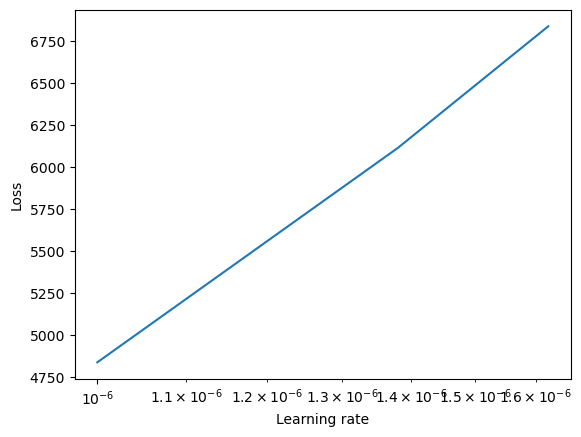

In [62]:
from lightning.pytorch.tuner import Tuner

# create a trainer for LR finding
lr_trainer = pl.Trainer(
    accelerator="cpu",
    gradient_clip_val=0.1,
    logger=False,
    enable_checkpointing=False,
    enable_progress_bar=False,
    enable_model_summary=False,
    callbacks=[],
    max_epochs=1,
)

# find the learning rate
lr_finder_result = Tuner(lr_trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

# ✅ This is the correct place to call .suggestion()
print(f"Suggested learning rate: {lr_finder_result.suggestion()}")

# plot the learning rate curve
fig = lr_finder_result.plot(show=True, suggest=True)
fig.show()


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.030199517204020167
Restoring states from the checkpoint path at c:\Users\dylan\Trying hard\Tryhard\v4 _Google_trend\.lr_find_cae7497d-31ce-4913-8562-82d1a0c03e5e.ckpt
Restored all states from the checkpoint at c:\Users\dylan\Trying hard\Tryhard\v4 _Google_trend\.lr_find_cae7497d-31ce-4913-8562-82d1a0c03e5e.ckpt


suggested learning rate: 0.030199517204020167


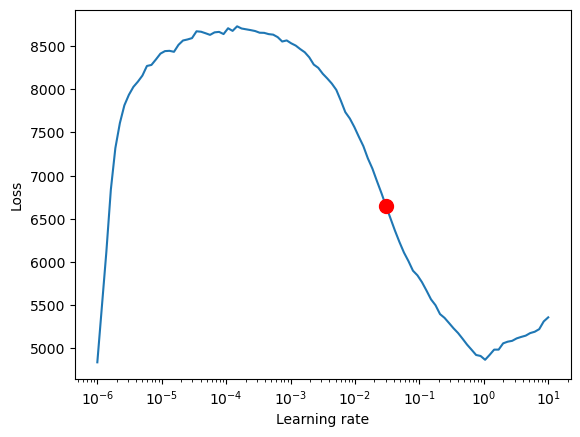

In [63]:
# find optimal learning rate
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

Train model

In [64]:
# configure network and trainer
early_stop_callback = EarlyStopping(
    monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min"
)
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=50,
    accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=50,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=2,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    optimizer="ranger",
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size() / 1e3:.1f}k")

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Number of parameters in network: 35.7k


In [68]:
from pytorch_forecasting import TemporalFusionTransformer

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=8,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=QuantileLoss(),
    optimizer="adam",  # ✅ Make sure it's set to "adam"
)



In [69]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)



   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 243    | train
3  | prescalers                         | ModuleDict                      | 448    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 1.1 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 10.5 K | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 928    | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 304    | train
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 304    

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 20784.182


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 5039.197 >= min_delta = 0.0. New best score: 15744.984


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 5367.227 >= min_delta = 0.0. New best score: 10377.758


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 4376.178 >= min_delta = 0.0. New best score: 6001.580


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 2080.278 >= min_delta = 0.0. New best score: 3921.302


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 422.491 >= min_delta = 0.0. New best score: 3498.811


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 5 records. Best score: 3498.811. Signaling Trainer to stop.


Hyperparameter tuning

In [72]:
%pip install optuna statsmodels optuna-integration


   ---------------------------------------- 0.0/386.6 kB ? eta -:--:--
   ---- ---------------------------------- 41.0/386.6 kB 991.0 kB/s eta 0:00:01
   ---------------------------------------- 386.6/386.6 kB 4.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/98.5 kB ? eta -:--:--
   ---------------------------------------- 98.5/98.5 kB 5.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/231.9 kB ? eta -:--:--
   --------------------------------------- 231.9/231.9 kB 13.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/78.5 kB ? eta -:--:--
   ---------------------------------------- 78.5/78.5 kB 4.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [12]:
import pickle

from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=200,
    max_epochs=50,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

[I 2025-05-17 16:53:22,396] A new study created in memory with name: no-name-fa852a63-5e4f-4a29-b02e-e901ab57d308
c:\Users\dylan\anaconda3\Lib\site-packages\pytorch_forecasting\models\temporal_fusion_transformer\tuning.py:142: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gradient_clip_val = trial.suggest_loguniform(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\dylan\anaconda3\Lib\site-packages\pytorch_forecasting\models\temporal_fusion_transformer\tuning.py:168: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout=trial.suggest_uniform("dropout", *dropout_range),
c:\Users\dylan\anaconda3\Lib\site-packages\lightn

{'gradient_clip_val': 0.010091966944842117, 'hidden_size': 35, 'dropout': 0.2877434273036876, 'hidden_continuous_size': 33, 'attention_head_size': 4, 'learning_rate': 0.01802249134253878}


In [14]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

NameError: name 'trainer' is not defined

In [13]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

NameError: name 'trainer' is not defined

#### GRU werkte niet

In [15]:
from pytorch_forecasting.models import RecurrentNetwork


Merge all real features into one list (shared known + unknown):

In [27]:
target_col = "Totaal_verkochte_wegvoertuigen"

# Only real-valued features (exclude target + time)
shared_real_features = [
    col for col in df_lagged.columns
    if col not in ["Periode", target_col, "time_idx", "groep", "maand", "jaar"]
]

# Optional: include lag features, Google Trends, fuel prices, sentiment, etc.
print("Real features used:", shared_real_features)


Real features used: ['thuis opladen', 'elektrische auto', 'hybride elektrisch', 'Bijtellingspercentage', 'Consumentenvertrouwen', 'Economisch klimaat', 'Koopbereidheid', 'Grote aankopen', 'BenzineEuro95_1_first', 'BenzineEuro95_1_last', 'BenzineEuro95_1_min', 'BenzineEuro95_1_max', 'BenzineEuro95_1_mean', 'Diesel_2_first', 'Diesel_2_last', 'Diesel_2_min', 'Diesel_2_max', 'Diesel_2_mean', 'Totaal_verkochte_wegvoertuigen_lag1', 'Totaal_verkochte_wegvoertuigen_lag2', 'month', 'log_sales']


In [37]:
target = "Totaal_verkochte_wegvoertuigen"

# Only real-valued inputs, excluding the time, target, and group columns
shared_reals = [
    col for col in df_lagged.columns
    if col not in ["Periode", "groep", "maand", "jaar", "time_idx", target]
]

# Add back essential features
shared_reals += ["time_idx", target]


In [40]:
target = "Totaal_verkochte_wegvoertuigen"

# All features except forbidden ones
shared_reals = [
    col for col in df_lagged.columns
    if col not in ["Periode", "groep", "maand", "jaar", "time_idx", target]
]

# Include time_idx but NOT the target
shared_reals += ["time_idx"]

# Now build the dataset
training = TimeSeriesDataSet(
    df_lagged[df_lagged.time_idx <= training_cutoff],
    time_idx="time_idx",
    target=target,
    group_ids=["groep"],
    min_encoder_length=max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=[],
    static_reals=[],
    time_varying_known_categoricals=["month", "jaar"],
    time_varying_known_reals=shared_reals,
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=shared_reals + [target],  # ✅ target only here
    target_normalizer=GroupNormalizer(groups=["groep"], transformation="softplus"),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    categorical_encoders={
        "month": NaNLabelEncoder(add_nan=True),
        "jaar": NaNLabelEncoder(add_nan=True),
        "groep": NaNLabelEncoder(add_nan=True),
    },
)


c:\Users\dylan\anaconda3\Lib\site-packages\pytorch_forecasting\data\encoders.py:400: UserWarning: Found 12 unknown classes which were set to NaN
  warnings.warn(
c:\Users\dylan\anaconda3\Lib\site-packages\pytorch_forecasting\data\encoders.py:400: UserWarning: Found 1 unknown classes which were set to NaN
  warnings.warn(


In [41]:
# Validation set
validation = TimeSeriesDataSet.from_dataset(training, df_lagged, predict=True, stop_randomization=True)

# Dataloaders
train_dataloader = training.to_dataloader(train=True, batch_size=64, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=640, num_workers=0)


c:\Users\dylan\anaconda3\Lib\site-packages\pytorch_forecasting\data\encoders.py:400: UserWarning: Found 1 unknown classes which were set to NaN
  warnings.warn(
c:\Users\dylan\anaconda3\Lib\site-packages\pytorch_forecasting\data\encoders.py:400: UserWarning: Found 12 unknown classes which were set to NaN
  warnings.warn(
c:\Users\dylan\anaconda3\Lib\site-packages\pytorch_forecasting\data\encoders.py:400: UserWarning: Found 1 unknown classes which were set to NaN
  warnings.warn(


In [47]:
from pytorch_forecasting.models import RecurrentNetwork
from pytorch_forecasting.metrics import MAE  # You can also use RMSE, SMAPE, etc.

# Recreate the GRU model to match the current training dataset
gru_model = RecurrentNetwork.from_dataset(
    training,
    cell_type="GRU",
    hidden_size=64,
    dropout=0.1,
    learning_rate=1e-3,
    log_interval=10,
    log_val_interval=1,
    loss=MAE()
)

trainer = pl.Trainer(max_epochs=30, accelerator="cpu")
trainer.fit(gru_model, train_dataloader, val_dataloader)

c:\Users\dylan\anaconda3\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\dylan\anaconda3\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name             | Type           | Params | Mode 
------------------------------------------------------------
0 | loss             | MAE            | 0      | train
1 | logging_m

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\dylan\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


RuntimeError: input.size(-1) must be equal to input_size. Expected 43, got 66

In [45]:
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import lightning.pytorch as pl

early_stop_callback = EarlyStopping(monitor="val_loss", patience=5, mode="min")
lr_logger = LearningRateMonitor()
logger = TensorBoardLogger("lightning_logs", name="gru_model")

trainer = pl.Trainer(
    max_epochs=30,
    accelerator="cpu",  # or "auto" if you want to use GPU if available
    callbacks=[early_stop_callback, lr_logger],
    logger=logger
)

# Recreate the GRU model to match the current training dataset
from pytorch_forecasting.models import RecurrentNetwork
from pytorch_forecasting.metrics import QuantileLoss

gru_model = RecurrentNetwork.from_dataset(
    training,
    cell_type="GRU",
    hidden_size=64,
    dropout=0.1,
    learning_rate=1e-3,
    log_interval=10,
    log_val_interval=1,
    loss=QuantileLoss()
)

trainer.fit(gru_model, train_dataloader, val_dataloader)


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\dylan\anaconda3\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\dylan\anaconda3\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


AssertionError: QuantileLoss does not work with recurrent network

In [30]:
from pytorch_forecasting.data import TimeSeriesDataSet
from pytorch_forecasting.data.encoders import NaNLabelEncoder, GroupNormalizer

training = TimeSeriesDataSet(
    df_lagged[df_lagged.time_idx <= training_cutoff],
    time_idx="time_idx",
    target=target_col,
    group_ids=["groep"],
    min_encoder_length=max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=[],
    static_reals=[],
    time_varying_known_categoricals=["month", "jaar"],
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=shared_reals,
    target_normalizer=GroupNormalizer(groups=["groep"], transformation="softplus"),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    categorical_encoders={
        "month": NaNLabelEncoder(add_nan=True),
        "jaar": NaNLabelEncoder(add_nan=True),
        "groep": NaNLabelEncoder(add_nan=True),
    },
)


In [31]:
# Merge reals (known and unknown) so they are the same for encoder and decoder
shared_reals = real_features + ["Totaal_verkochte_wegvoertuigen"]


 Rebuild your TimeSeriesDataSet like this:

In [24]:
from pytorch_forecasting.data import TimeSeriesDataSet
from pytorch_forecasting.data.encoders import NaNLabelEncoder, GroupNormalizer

training = TimeSeriesDataSet(
    df_lagged[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="Totaal_verkochte_wegvoertuigen",
    group_ids=["groep"],
    min_encoder_length=max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=[],
    static_reals=[],
    time_varying_known_categoricals=categorical_features,
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=shared_reals,
    target_normalizer=GroupNormalizer(groups=["groep"], transformation="softplus"),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    categorical_encoders={
        "month": NaNLabelEncoder(add_nan=True),
        "jaar": NaNLabelEncoder(add_nan=True),
        "groep": NaNLabelEncoder(add_nan=True),
    }
)


Define the GRU model

In [33]:
validation = TimeSeriesDataSet.from_dataset(training, df_lagged, predict=True, stop_randomization=True)
train_dataloader = training.to_dataloader(train=True, batch_size=64, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=640, num_workers=0)


c:\Users\dylan\anaconda3\Lib\site-packages\pytorch_forecasting\data\encoders.py:400: UserWarning: Found 1 unknown classes which were set to NaN
  warnings.warn(


In [35]:
from pytorch_forecasting.models import RecurrentNetwork
from pytorch_forecasting.metrics import QuantileLoss

gru_model = RecurrentNetwork.from_dataset(
    training,
    cell_type="GRU",           # "LSTM" also supported
    hidden_size=64,
    dropout=0.1,
    learning_rate=1e-3,
    log_interval=10,
    log_val_interval=1,
    loss=QuantileLoss()
)


AssertionError: Encoder and decoder variables have to be the same apart from target variable

In [36]:
from lightning.pytorch import Trainer

trainer = Trainer(max_epochs=30, accelerator="cpu")
trainer.fit(gru_model, train_dataloader, val_dataloader)


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


NameError: name 'gru_model' is not defined

In [25]:
from pytorch_forecasting.models import RecurrentNetwork

gru_model = RecurrentNetwork.from_dataset(
    training,
    cell_type="GRU",
    hidden_size=64,             # adjust as needed
    dropout=0.1,
    learning_rate=1e-3,         # can tune this
    log_interval=10,
    log_val_interval=1,
    loss=QuantileLoss()         # can also try MASE(), MAE(), etc.
)


c:\Users\dylan\anaconda3\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\dylan\anaconda3\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


AssertionError: Encoder and decoder variables have to be the same apart from target variable

Define the Trainer

In [ ]:
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger

early_stop_callback = EarlyStopping(monitor="val_loss", patience=5, mode="min")
lr_logger = LearningRateMonitor()
logger = TensorBoardLogger("lightning_logs", name="gru_forecast")

trainer = Trainer(
    max_epochs=30,
    accelerator="cpu",  # or "gpu" if available
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback, lr_logger],
    logger=logger,
)


Make predictions (optional)


In [ ]:
from pytorch_forecasting.metrics import MAE

predictions = gru_model.predict(val_dataloader, return_y=True)
print("MAE:", MAE()(predictions.output, predictions.y))

#### LightGBM

In [48]:
%pip install lightgbm

 Prepare the dataset for LightGBM

In [49]:
from sklearn.model_selection import train_test_split

# Define target and features
target_col = "Totaal_verkochte_wegvoertuigen"
feature_cols = [col for col in df_lagged.columns if col not in ["Periode", target_col]]

# Drop NA rows if there are any
df_lagged = df_lagged.dropna(subset=feature_cols + [target_col])

# Split train/test
train_df = df_lagged[df_lagged["time_idx"] <= df_lagged["time_idx"].max() - 6]
test_df = df_lagged[df_lagged["time_idx"] > df_lagged["time_idx"].max() - 6]

X_train = train_df[feature_cols]
y_train = train_df[target_col]

X_test = test_df[feature_cols]
y_test = test_df[target_col]


Train a LightGBM model

In [52]:
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Convert 'jaar' and 'groep' to string type for LightGBM compatibility
X_train = X_train.copy()
X_test = X_test.copy()
X_train['jaar'] = X_train['jaar'].astype('category')
X_train['groep'] = X_train['groep'].astype('category')
X_test['jaar'] = X_test['jaar'].astype('category')
X_test['groep'] = X_test['groep'].astype('category')

lgb_model = lgb.LGBMRegressor(
    objective="regression",
    boosting_type="gbdt",
    learning_rate=0.05,
    n_estimators=100,
    max_depth=6,
    random_state=42,
)

lgb_model.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,000507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1333
[LightGBM] [Info] Number of data points in the train set: 209, number of used features: 24
[LightGBM] [Info] Start training from score 5869,851675
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

LGBMRegressor(learning_rate=0.05, max_depth=6, objective='regression',
              random_state=42)

eValuate the model

In [54]:
y_pred = lgb_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape = (abs((y_test - y_pred) / y_test).mean()) * 100

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")


MAE: 6555.12
RMSE: 7645.44
R²: -1.4903
MAPE: 19.49%


fEature importance

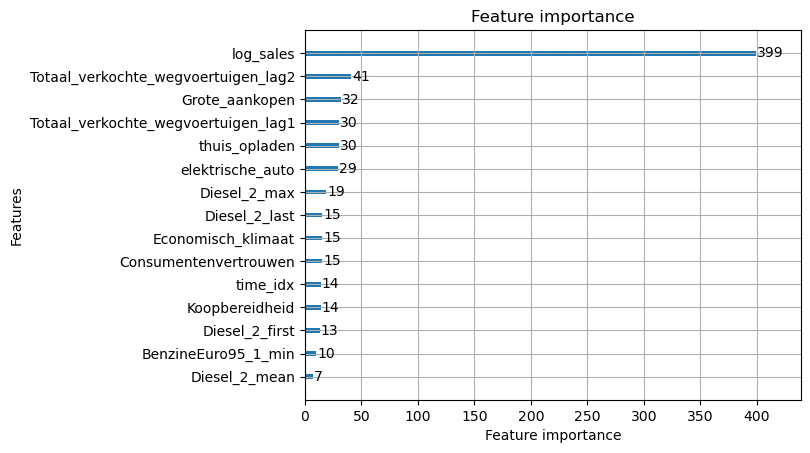

In [55]:
import matplotlib.pyplot as plt

lgb.plot_importance(lgb_model, max_num_features=15)
plt.show()


Gridsearch

In [56]:
from sklearn.model_selection import GridSearchCV

params = {
    "num_leaves": [15, 31, 63],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [100, 200]
}

grid = GridSearchCV(lgb_model, params, cv=3, scoring="neg_mean_absolute_error", verbose=1)
grid.fit(X_train, y_train)

print(grid.best_params_)


Fitting 3 folds for each of 54 candidates, totalling 162 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0,000585 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 139, number of used features: 24
[LightGBM] [Info] Start training from score 8589,374101
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

In [57]:
# Train LightGBM model with best parameters from grid search
best_lgb_model = lgb.LGBMRegressor(
    **grid.best_params_,
    objective="regression",
    boosting_type="gbdt",
    random_state=42,
)

best_lgb_model.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,000157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1333
[LightGBM] [Info] Number of data points in the train set: 209, number of used features: 24
[LightGBM] [Info] Start training from score 5869,851675
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

LGBMRegressor(max_depth=3, n_estimators=200, num_leaves=15,
              objective='regression', random_state=42)

In [59]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd


In [60]:
lgbm = LGBMRegressor(
    objective="regression",
    random_state=42,
    n_estimators=200,
    max_depth=3,
    num_leaves=15
)


In [62]:
df_lagged = df_lagged.sort_values("Periode")

# Example target and features
target = "Totaal_verkochte_wegvoertuigen"
feature_cols = [col for col in df_lagged.columns if col not in ["Periode", target]]

X = df_lagged[feature_cols]
y = df_lagged[target]


In [65]:
tscv = TimeSeriesSplit(n_splits=5)

results = []
for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Ensure 'jaar' and 'groep' are categorical for LightGBM
    for col in ['jaar', 'groep']:
        if col in X_train.columns:
            X_train[col] = X_train[col].astype('category')
            X_test[col] = X_test[col].astype('category')

    lgbm.fit(X_train, y_train)
    y_pred = lgbm.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    print(f"Fold {fold + 1}")
    print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.4f}, MAPE: {mape:.2f}%\n")

    results.append((rmse, mae, r2, mape))

# Average scores
rmse_avg, mae_avg, r2_avg, mape_avg = np.mean(results, axis=0)
print("=== Averages ===")
print(f"Average RMSE: {rmse_avg:.2f}")
print(f"Average MAE: {mae_avg:.2f}")
print(f"Average R²: {r2_avg:.4f}")
print(f"Average MAPE: {mape_avg:.2f}%")


C:\Users\dylan\AppData\Local\Temp\ipykernel_37768\1383338609.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = X_train[col].astype('category')
C:\Users\dylan\AppData\Local\Temp\ipykernel_37768\1383338609.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = X_test[col].astype('category')
C:\Users\dylan\AppData\Local\Temp\ipykernel_37768\1383338609.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,000054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18
[LightGBM] [Info] Number of data points in the train set: 40, number of used features: 2
[LightGBM] [Info] Start training from score 302,750000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with p

#### Holt

In [67]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd


In [68]:
# Ensure it's sorted and set Periode as index
df_hw = df_lagged[["Periode", "Totaal_verkochte_wegvoertuigen"]].copy()
df_hw = df_hw.sort_values("Periode")
df_hw.set_index("Periode", inplace=True)

# Train/test split (e.g., last 6 months = test)
train = df_hw.iloc[:-6]
test = df_hw.iloc[-6:]


In [69]:
model = ExponentialSmoothing(
    train["Totaal_verkochte_wegvoertuigen"],
    trend="add",
    seasonal="add",
    seasonal_periods=12  # or 6, depending on your seasonality
).fit()

forecast = model.forecast(len(test))


c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [71]:
y_true = test["Totaal_verkochte_wegvoertuigen"]
y_pred = forecast

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")


MAE: 5559.95
RMSE: 6886.78
R²: -1.0206
MAPE: 16.36%


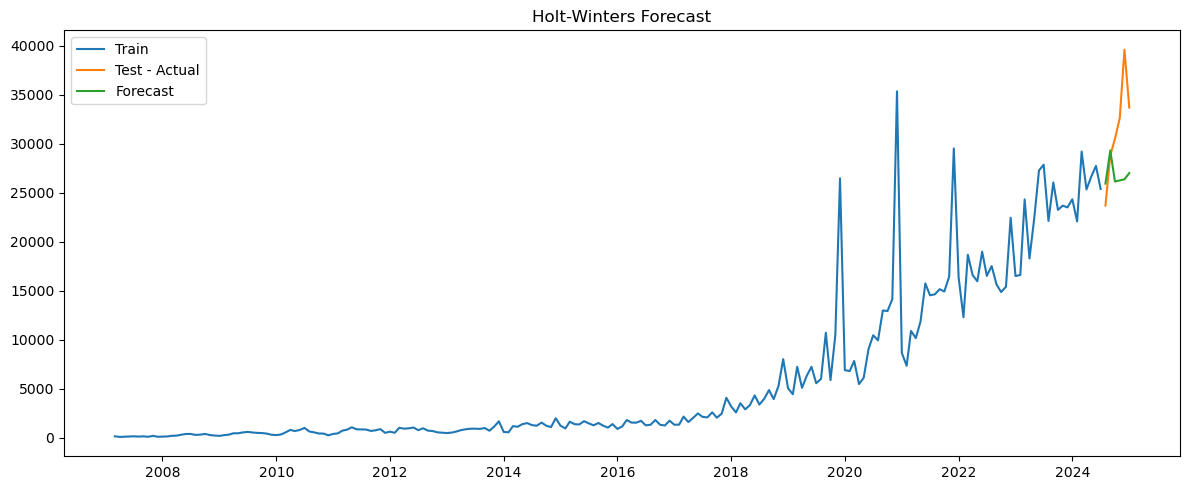

In [72]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(train.index, train["Totaal_verkochte_wegvoertuigen"], label="Train")
plt.plot(test.index, y_true, label="Test - Actual")
plt.plot(test.index, y_pred, label="Forecast")
plt.title("Holt-Winters Forecast")
plt.legend()
plt.tight_layout()
plt.show()


Fold 1
MAE: 146.80, RMSE: 157.08, R²: 0.5639, MAPE: 35.29%



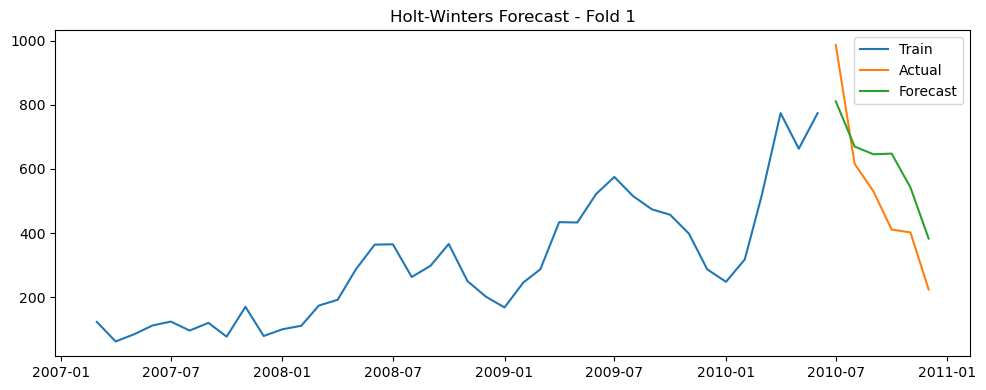

Fold 2
MAE: 202.58, RMSE: 267.17, R²: -3.5060, MAPE: 20.63%



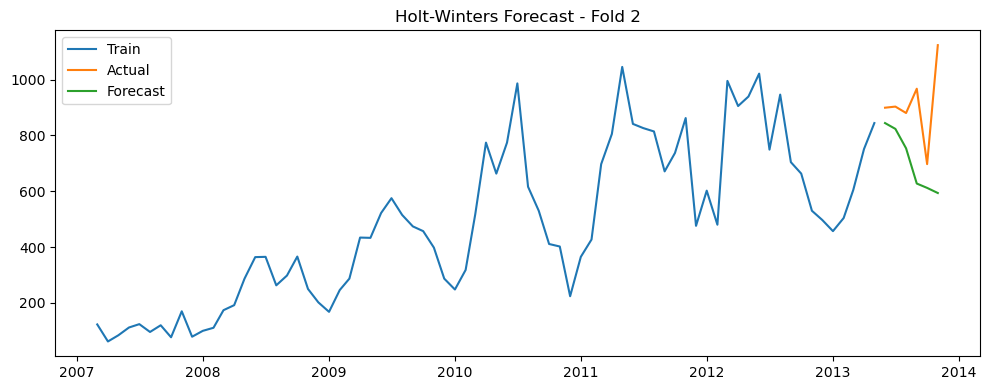

Fold 3
MAE: 150.08, RMSE: 183.67, R²: 0.2428, MAPE: 10.86%



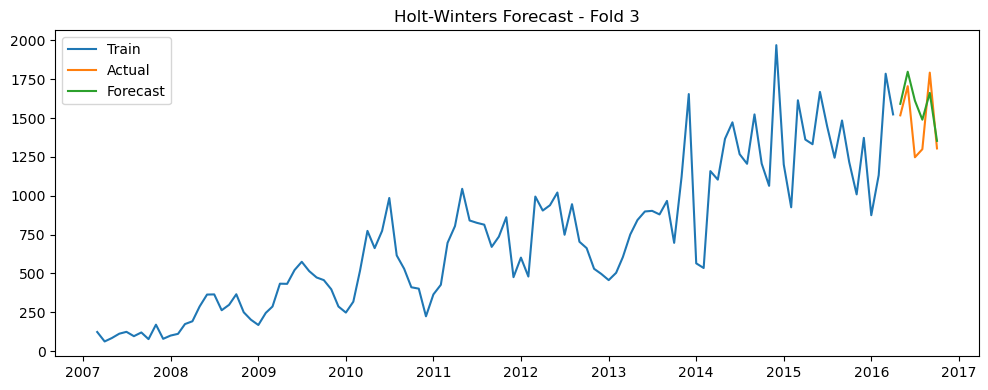

Fold 4
MAE: 833.63, RMSE: 1087.22, R²: 0.6595, MAPE: 11.16%



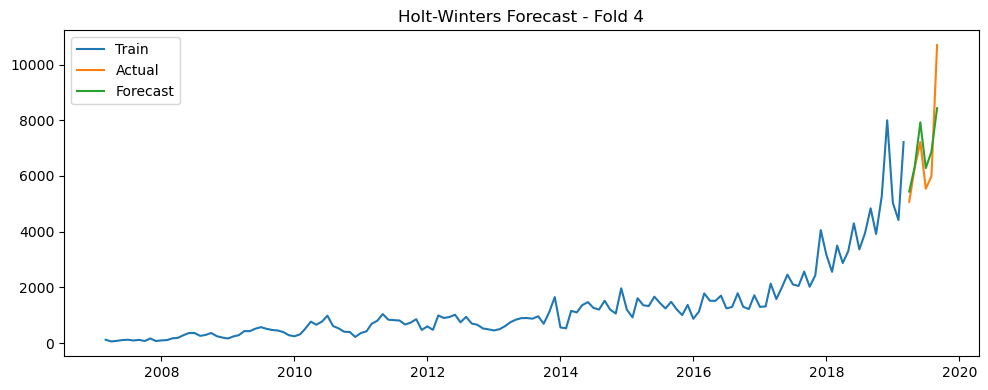

c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Fold 5
MAE: 4371.26, RMSE: 5439.99, R²: -22.1687, MAPE: 25.23%



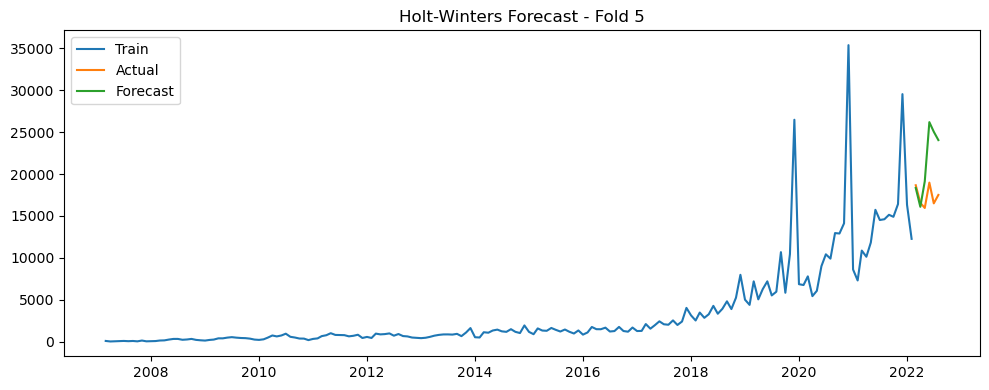

=== Average Performance Over All Folds ===
Average MAE:   1140.87
Average RMSE:  1427.03
Average R²:    -4.8417
Average MAPE:  20.63%


In [79]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Prepare data
df_hw = df_lagged[["Periode", "Totaal_verkochte_wegvoertuigen"]].copy()
df_hw = df_hw.sort_values("Periode").reset_index(drop=True)

# Extract target and time
y = df_hw["Totaal_verkochte_wegvoertuigen"].values
periods = df_hw["Periode"].values

# Use TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
results = []
forecast_horizon = 6

for fold, (train_idx, val_idx) in enumerate(tscv.split(y)):
    y_train = y[train_idx]
    y_val_full = y[val_idx]
    periods_train = periods[train_idx]
    periods_val_full = periods[val_idx]

    # Only evaluate first 6 months in validation
    if len(y_val_full) < forecast_horizon:
        print(f"Fold {fold + 1} skipped: not enough validation data for 6-month forecast.")
        continue

    y_val = y_val_full[:forecast_horizon]
    periods_val = periods_val_full[:forecast_horizon]

    try:
        model = ExponentialSmoothing(
            y_train,
            trend="add",
            seasonal="multiplicative",
            seasonal_periods=12  # Adjust if seasonality is known to be different
        ).fit()

        y_pred = model.forecast(steps=forecast_horizon)

        # Metrics
        mae = mean_absolute_error(y_val, y_pred)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        r2 = r2_score(y_val, y_pred)
        mape = np.mean(np.abs((y_val - y_pred) / y_val)) * 100

        results.append((mae, rmse, r2, mape))

        print(f"Fold {fold + 1}")
        print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}, MAPE: {mape:.2f}%\n")

        # Optional plot
        plt.figure(figsize=(10, 4))
        plt.plot(periods_train, y_train, label="Train")
        plt.plot(periods_val, y_val, label="Actual")
        plt.plot(periods_val, y_pred, label="Forecast")
        plt.title(f"Holt-Winters Forecast - Fold {fold + 1}")
        plt.legend()
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Fold {fold + 1} failed: {e}")
        continue

# Summary
if results:
    mae_avg, rmse_avg, r2_avg, mape_avg = np.mean(results, axis=0)
    print("=== Average Performance Over All Folds ===")
    print(f"Average MAE:   {mae_avg:.2f}")
    print(f"Average RMSE:  {rmse_avg:.2f}")
    print(f"Average R²:    {r2_avg:.4f}")
    print(f"Average MAPE:  {mape_avg:.2f}%")
else:
    print("No successful folds to average. Please check for errors in model fitting.")


In [85]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
import numpy as np

# --- Feature engineering: add lag features ---
df_rf = df_lagged.copy()
df_rf['Periode'] = pd.to_datetime(df_rf['Periode'])
df_rf = df_rf.sort_values('Periode').reset_index(drop=True)

# Lag features for the target variable
df_rf['lag1'] = df_rf['Totaal_verkochte_wegvoertuigen'].shift(1)
df_rf['lag2'] = df_rf['Totaal_verkochte_wegvoertuigen'].shift(2)

# Drop rows with NA lags
df_rf = df_rf.dropna(subset=['lag1', 'lag2']).reset_index(drop=True)

# --- Prepare features and target ---
exclude_cols = ['Periode', 'Totaal_verkochte_wegvoertuigen', 'jaar', 'groep', 'month', 'log_sales']
feature_cols = [col for col in df_rf.columns if col not in exclude_cols]
X = df_rf[feature_cols]
y = df_rf['Totaal_verkochte_wegvoertuigen']

# --- Cross-validation setup ---
tscv = TimeSeriesSplit(n_splits=5)
rmse_scores, mae_scores, r2_scores, mape_scores = [], [], [], []

for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / np.maximum(y_test, 1))) * 100  # Avoid divide by zero

    rmse_scores.append(rmse)
    mae_scores.append(mae)
    r2_scores.append(r2)
    mape_scores.append(mape)

    print(f"📂 Fold {fold+1}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAE:  {mae:.2f}")
    print(f"  R²:   {r2:.4f}")
    print(f"  MAPE: {mape:.2f}%\n")

# --- Aggregate results ---
print("=== 📊 Average Metrics Over All Folds ===")
print(f"Average RMSE:  {np.mean(rmse_scores):.2f}")
print(f"Average MAE:   {np.mean(mae_scores):.2f}")
print(f"Average R²:    {np.mean(r2_scores):.4f}")
print(f"Average MAPE:  {np.mean(mape_scores):.2f}%")


📂 Fold 1
  RMSE: 184.50
  MAE:  152.75
  R²:   0.2377
  MAPE: 24.55%

📂 Fold 2
  RMSE: 538.70
  MAE:  459.42
  R²:   -1.7122
  MAPE: 35.02%

📂 Fold 3
  RMSE: 2376.90
  MAE:  1709.24
  R²:   -1.0912
  MAPE: 44.96%

📂 Fold 4
  RMSE: 8797.24
  MAE:  5921.26
  R²:   -0.7190
  MAPE: 37.92%

📂 Fold 5
  RMSE: 7489.04
  MAE:  5906.41
  R²:   -0.6424
  MAPE: 22.76%

=== 📊 Average Metrics Over All Folds ===
Average RMSE:  3877.27
Average MAE:   2829.81
Average R²:    -0.7854
Average MAPE:  33.04%


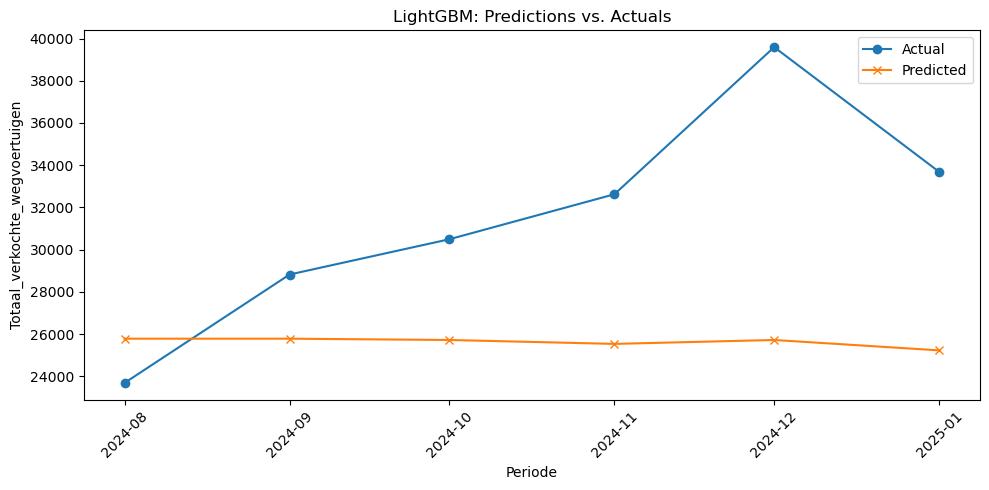

In [88]:
import matplotlib.pyplot as plt

# Plot predictions vs. actuals for the test set
plt.figure(figsize=(10, 5))
plt.plot(test.index, y_true, label="Actual", marker='o')
# Use the same feature columns as during training, including 'jaar' and 'groep'
feature_cols = [col for col in test_df.columns if col not in ['Periode', 'Totaal_verkochte_wegvoertuigen']]
X_test = test_df[feature_cols].copy()
X_test['jaar'] = X_test['jaar'].astype('category')
X_test['groep'] = X_test['groep'].astype('category')

plt.plot(test.index, lgb_model.predict(X_test), label="Predicted", marker='x')
plt.title("LightGBM: Predictions vs. Actuals")
plt.xlabel("Periode")
plt.ylabel("Totaal_verkochte_wegvoertuigen")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Prophet 

In [90]:
! pip install prophet


   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/13.3 MB 991.0 kB/s eta 0:00:14
   --- ------------------------------------ 1.2/13.3 MB 15.6 MB/s eta 0:00:01
   ------------ --------------------------- 4.1/13.3 MB 33.0 MB/s eta 0:00:01
   ---------------- ----------------------- 5.4/13.3 MB 31.6 MB/s eta 0:00:01
   --------------------- ------------------ 7.1/13.3 MB 32.5 MB/s eta 0:00:01
   ---------------------------- ----------- 9.6/13.3 MB 36.2 MB/s eta 0:00:01
   ---------------------------------- ----- 11.5/13.3 MB 46.7 MB/s eta 0:00:01
   ---------------------------------- ----- 11.5/13.3 MB 46.7 MB/s eta 0:00:01
   ---------------------------------------  13.3/13.3 MB 34.4 MB/s eta 0:00:01
   ---------------------------------------  13.3/13.3 MB 34.4 MB/s eta 0:00:01
   ---------------------------------------  13.3/13.3 MB 34.4 MB/s eta 0:00:01
   ---------------------------------------  13.3/13.3 MB 34.4 MB/s

In [91]:
from prophet import Prophet
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

# --- Prepare data ---
df_prophet = df_lagged[["Periode", "Totaal_verkochte_wegvoertuigen"]].copy()
df_prophet.columns = ["ds", "y"]  # Prophet expects these names
df_prophet["ds"] = pd.to_datetime(df_prophet["ds"])
df_prophet = df_prophet.sort_values("ds").reset_index(drop=True)

# --- Cross-validation ---
tscv = TimeSeriesSplit(n_splits=5)
results = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(df_prophet)):
    train_df = df_prophet.iloc[train_idx].copy()
    val_df = df_prophet.iloc[val_idx].copy()

    model = Prophet()
    model.fit(train_df)

    future = val_df[["ds"]].copy()
    forecast = model.predict(future)
    y_pred = forecast["yhat"].values
    y_true = val_df["y"].values

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, 1))) * 100

    results.append((mae, rmse, r2, mape))

    print(f"📂 Fold {fold+1}")
    print(f"  MAE:  {mae:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  R²:   {r2:.4f}")
    print(f"  MAPE: {mape:.2f}%\n")

# --- Summary ---
mae_avg, rmse_avg, r2_avg, mape_avg = np.mean(results, axis=0)
print("=== 📊 Average Performance Over All Folds ===")
print(f"Average MAE:   {mae_avg:.2f}")
print(f"Average RMSE:  {rmse_avg:.2f}")
print(f"Average R²:    {r2_avg:.4f}")
print(f"Average MAPE:  {mape_avg:.2f}%")


18:03:16 - cmdstanpy - INFO - Chain [1] start processing
18:03:17 - cmdstanpy - INFO - Chain [1] done processing
18:03:17 - cmdstanpy - INFO - Chain [1] start processing


📂 Fold 1
  MAE:  190.21
  RMSE: 238.84
  R²:   -0.2774
  MAPE: 34.88%



18:03:17 - cmdstanpy - INFO - Chain [1] done processing
18:03:18 - cmdstanpy - INFO - Chain [1] start processing
18:03:18 - cmdstanpy - INFO - Chain [1] done processing


📂 Fold 2
  MAE:  299.48
  RMSE: 391.47
  R²:   -0.4322
  MAPE: 22.53%

📂 Fold 3
  MAE:  1361.27
  RMSE: 2019.18
  R²:   -0.5091
  MAPE: 34.38%



18:03:18 - cmdstanpy - INFO - Chain [1] start processing
18:03:18 - cmdstanpy - INFO - Chain [1] done processing
18:03:18 - cmdstanpy - INFO - Chain [1] start processing
18:03:18 - cmdstanpy - INFO - Chain [1] done processing


📂 Fold 4
  MAE:  5229.78
  RMSE: 8012.03
  R²:   -0.4258
  MAPE: 33.54%

📂 Fold 5
  MAE:  3281.58
  RMSE: 4237.73
  R²:   0.4741
  MAPE: 12.94%

=== 📊 Average Performance Over All Folds ===
Average MAE:   2072.46
Average RMSE:  2979.85
Average R²:    -0.2341
Average MAPE:  27.66%


18:03:58 - cmdstanpy - INFO - Chain [1] start processing
18:03:58 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\dylan\anaconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


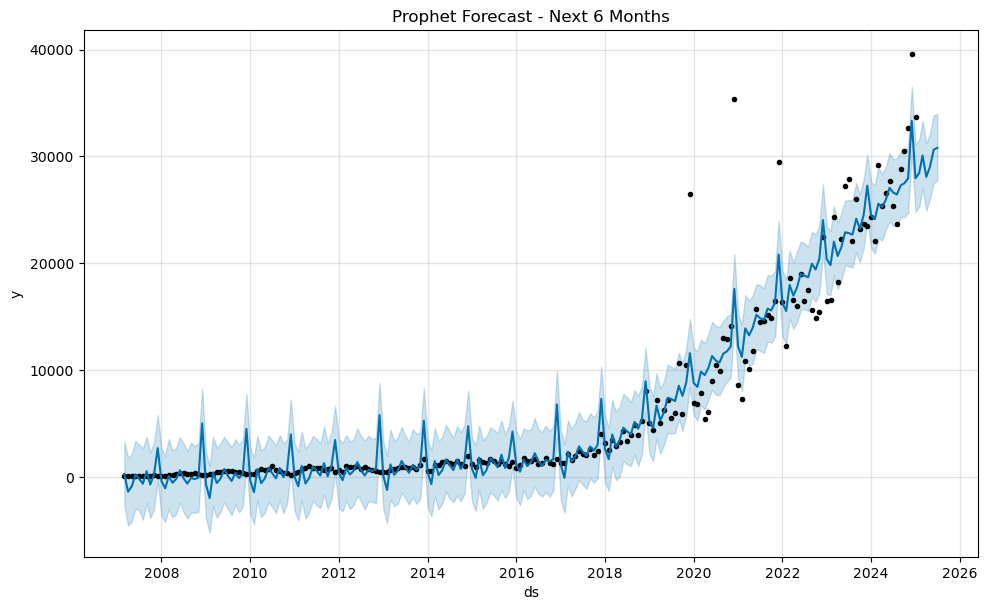

In [92]:
# Fit on all data
final_model = Prophet()
final_model.fit(df_prophet)

# Forecast 6 months into the future
future_dates = final_model.make_future_dataframe(periods=6, freq="M")
forecast = final_model.predict(future_dates)

# Plot forecast
final_model.plot(forecast)
plt.title("Prophet Forecast - Next 6 Months")
plt.show()


18:05:54 - cmdstanpy - INFO - Chain [1] start processing
18:05:55 - cmdstanpy - INFO - Chain [1] done processing


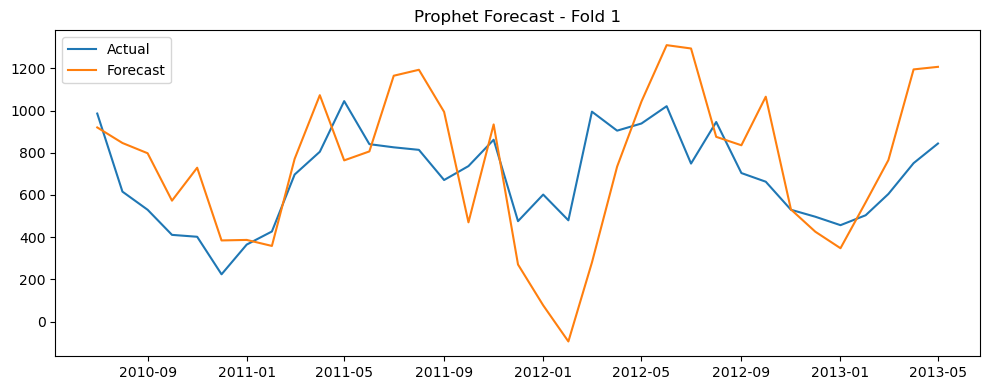

18:05:55 - cmdstanpy - INFO - Chain [1] start processing



📂 Fold 1
  MAE:  236.85
  RMSE: 294.33
  R²:   -0.9400
  MAPE: 36.69%


18:05:56 - cmdstanpy - INFO - Chain [1] done processing


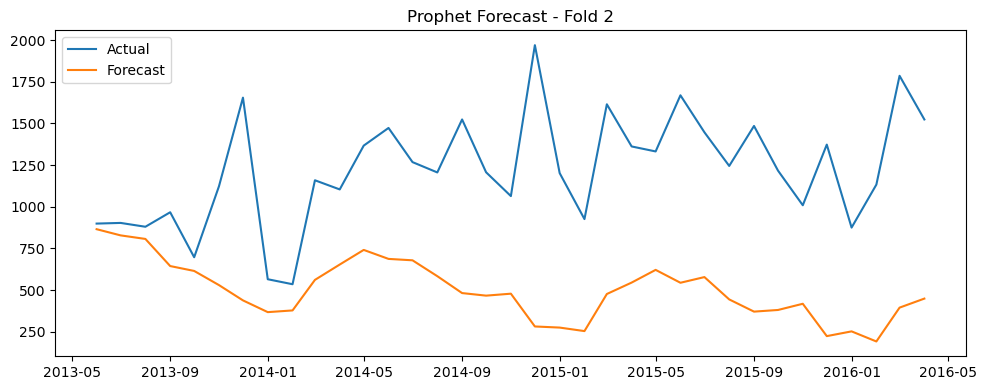

18:05:56 - cmdstanpy - INFO - Chain [1] start processing
18:05:56 - cmdstanpy - INFO - Chain [1] done processing



📂 Fold 2
  MAE:  721.85
  RMSE: 820.73
  R²:   -5.2955
  MAPE: 55.16%


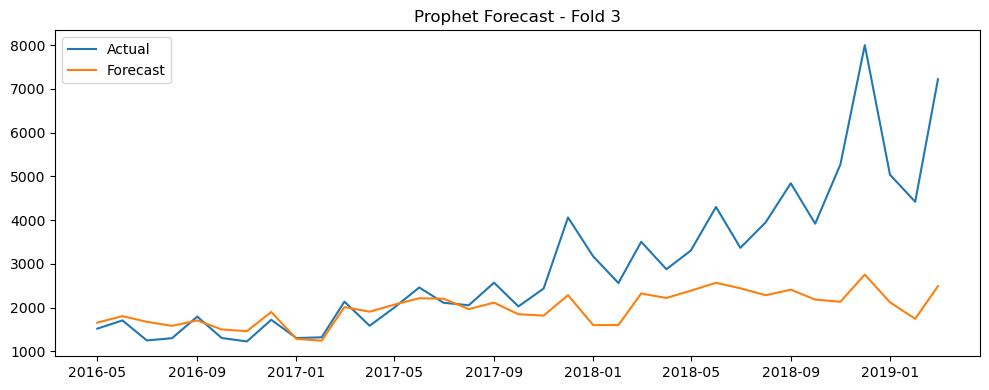

18:05:57 - cmdstanpy - INFO - Chain [1] start processing
18:05:57 - cmdstanpy - INFO - Chain [1] done processing



📂 Fold 3
  MAE:  1091.22
  RMSE: 1702.30
  R²:   -0.0726
  MAPE: 27.33%


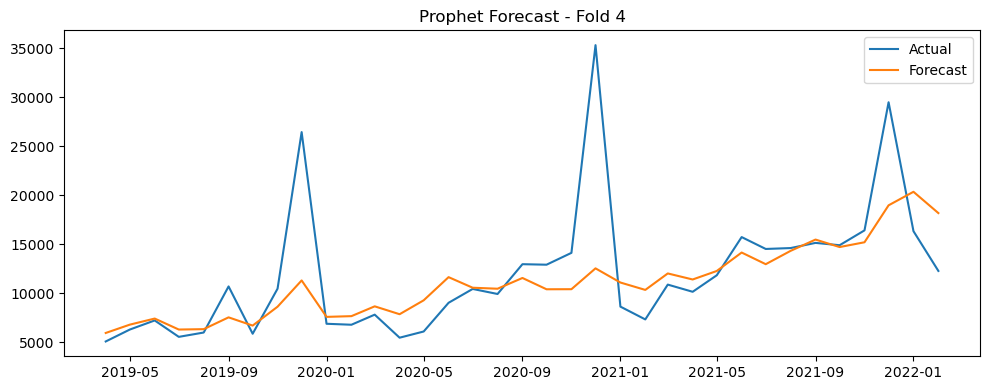

18:05:57 - cmdstanpy - INFO - Chain [1] start processing
18:05:58 - cmdstanpy - INFO - Chain [1] done processing



📂 Fold 4
  MAE:  2837.07
  RMSE: 5342.80
  R²:   0.3660
  MAPE: 19.74%


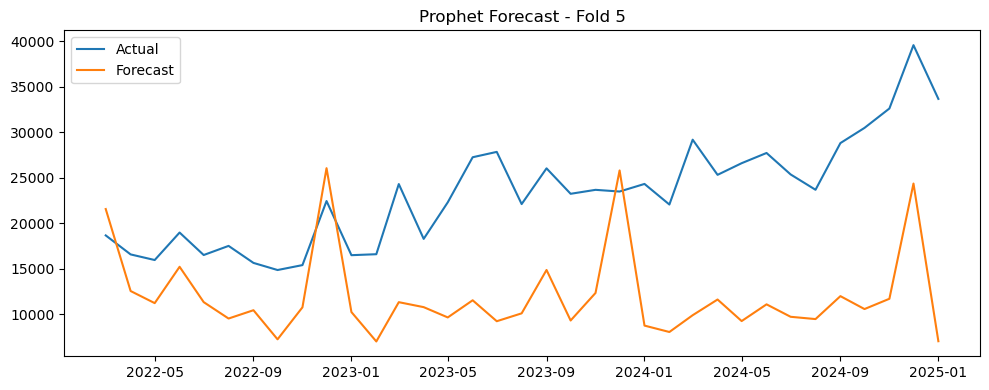


📂 Fold 5
  MAE:  11715.28
  RMSE: 13169.47
  R²:   -4.0787
  MAPE: 48.14%

=== 📊 Average Performance Over All Folds ===
Average MAE:   3320.46
Average RMSE:  4265.93
Average R²:    -2.0042
Average MAPE:  37.41%


In [93]:
from prophet import Prophet
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ==== Prepare Data ====
df_prophet = df_lagged.copy()
df_prophet["ds"] = pd.to_datetime(df_prophet["Periode"])
df_prophet["y"] = df_prophet["Totaal_verkochte_wegvoertuigen"]

# Define regressors to include (must exist in df_prophet!)
regressors = [
    "Bijtellingspercentage",
    "elektrische auto",
    "Consumentenvertrouwen"
    # Add more if you want
]

# Remove rows with NaNs in any of these
df_prophet = df_prophet[["ds", "y"] + regressors].dropna().reset_index(drop=True)

# === Cross-validation ===
tscv = TimeSeriesSplit(n_splits=5)
results = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(df_prophet)):
    train_df = df_prophet.iloc[train_idx].copy()
    val_df = df_prophet.iloc[val_idx].copy()

    # === Define and train Prophet ===
    model = Prophet(
        seasonality_mode="multiplicative",
        changepoint_prior_scale=0.1,
        changepoint_range=0.9
    )

    # Add regressors
    for reg in regressors:
        model.add_regressor(reg)

    model.fit(train_df)

    # === Forecast ===
    future = val_df[["ds"] + regressors].copy()
    forecast = model.predict(future)

    # === Evaluation ===
    y_true = val_df["y"].values
    y_pred = forecast["yhat"].values

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    results.append((mae, rmse, r2, mape))

    # === Optional Plot ===
    plt.figure(figsize=(10, 4))
    plt.plot(val_df["ds"], y_true, label="Actual")
    plt.plot(val_df["ds"], y_pred, label="Forecast")
    plt.title(f"Prophet Forecast - Fold {fold+1}")
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"\n📂 Fold {fold+1}")
    print(f"  MAE:  {mae:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  R²:   {r2:.4f}")
    print(f"  MAPE: {mape:.2f}%")

# === Summary ===
if results:
    avg_mae, avg_rmse, avg_r2, avg_mape = np.mean(results, axis=0)
    print("\n=== 📊 Average Performance Over All Folds ===")
    print(f"Average MAE:   {avg_mae:.2f}")
    print(f"Average RMSE:  {avg_rmse:.2f}")
    print(f"Average R²:    {avg_r2:.4f}")
    print(f"Average MAPE:  {avg_mape:.2f}%")
else:
    print("⚠️ No successful folds.")


In [94]:
# Gebruik je volledige dataset
df_full = df_prophet.copy()

# Model
model = Prophet(
    seasonality_mode="multiplicative",
    changepoint_prior_scale=0.1,
    changepoint_range=0.9
)

# Voeg regressors toe
for reg in regressors:
    model.add_regressor(reg)

# Train op alles
model.fit(df_full)


18:27:59 - cmdstanpy - INFO - Chain [1] start processing
18:27:59 - cmdstanpy - INFO - Chain [1] done processing


In [95]:
# Maak een nieuwe future-tijdreeks van 6 maanden
future_dates = pd.date_range(start=df_full["ds"].max() + pd.DateOffset(months=1), periods=6, freq="MS")
future_df = pd.DataFrame({"ds": future_dates})

# Voorbeeld: gebruik de laatst bekende waarde van elke regressor
for reg in regressors:
    future_df[reg] = df_full[reg].iloc[-1]  # of hier handmatig toekomstige waardes invullen


In [96]:
# Combineer oude + nieuwe data
future_all = pd.concat([df_full[["ds"] + regressors], future_df], ignore_index=True)

# Voorspel
forecast = model.predict(future_all)

# Laatste 6 maanden
forecast_tail = forecast[forecast["ds"].isin(future_dates)][["ds", "yhat", "yhat_lower", "yhat_upper"]]
print(forecast_tail)


            ds          yhat    yhat_lower    yhat_upper
215 2025-02-01  15751.419333  13185.697389  18206.838332
216 2025-03-01  30123.435263  27513.351876  32667.375491
217 2025-04-01  24797.964029  22219.174164  27169.509391
218 2025-05-01  28305.195719  25863.521973  30900.812375
219 2025-06-01  31932.297713  29470.700036  34605.427366
220 2025-07-01  29943.529548  27283.230901  32427.214327


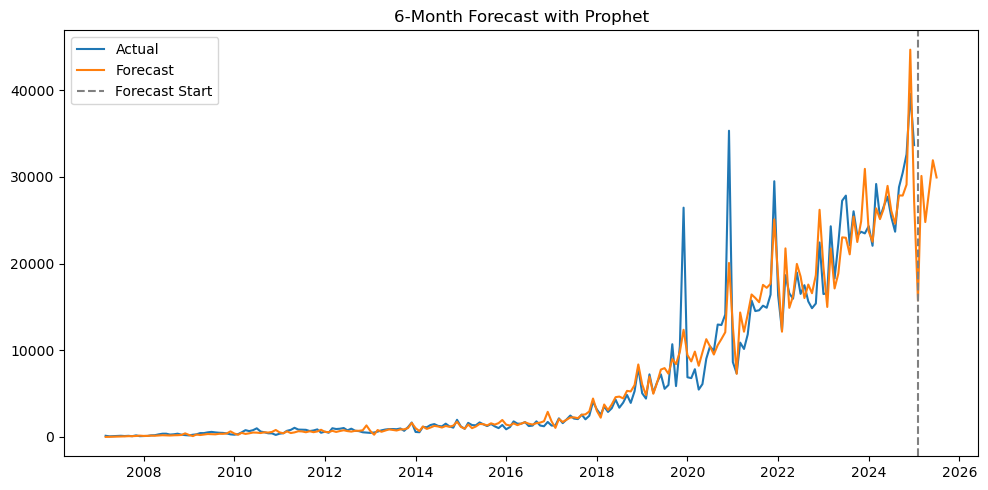

In [97]:
plt.figure(figsize=(10, 5))
plt.plot(df_full["ds"], df_full["y"], label="Actual")
plt.plot(forecast["ds"], forecast["yhat"], label="Forecast")
plt.axvline(x=future_dates.min(), color="gray", linestyle="--", label="Forecast Start")
plt.title("6-Month Forecast with Prophet")
plt.legend()
plt.tight_layout()
plt.show()


In [101]:
# Create actuals DataFrame for the last 6 months
df_actuals_6m = test.reset_index().rename(columns={"Periode": "ds", "Totaal_verkochte_wegvoertuigen": "y"})

# Merge predicted vs. actual
comparison = forecast_tail.merge(df_actuals_6m, on="ds", suffixes=("_pred", "_true"))

# Calculate metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

y_true = comparison["y"]
y_pred = comparison["yhat_pred"]

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Show results
print("=== 📈 Forecast Evaluation over 6 Months ===")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.4f}")
print(f"MAPE: {mape:.2f}%")


KeyError: 'yhat_pred'

In [98]:
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

MAE: 11715.28
RMSE: 13169.47
R²: -4.0787


18:31:04 - cmdstanpy - INFO - Chain [1] start processing
18:31:04 - cmdstanpy - INFO - Chain [1] done processing


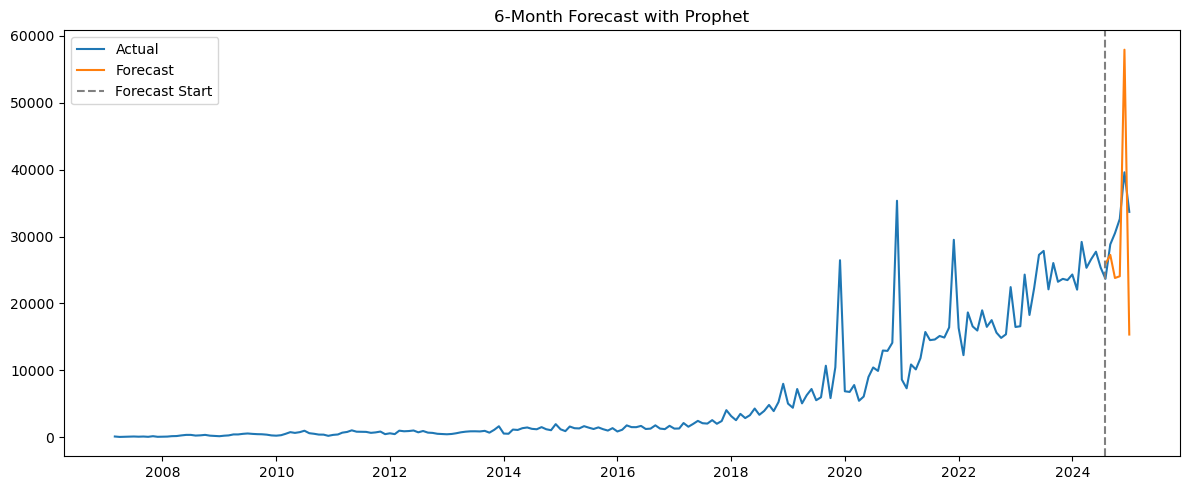

=== 📈 Forecast Evaluation over Last 6 Months ===
MAE:  9279.27
RMSE: 11522.58
R²:   -4.6566
MAPE: 27.28%


In [103]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ==== Prepare Data ====
df_prophet = df_lagged.copy()
df_prophet["ds"] = pd.to_datetime(df_prophet["Periode"])
df_prophet["y"] = df_prophet["Totaal_verkochte_wegvoertuigen"]

# Define regressors (must exist in df_prophet!)
regressors = [
    "Bijtellingspercentage",
    "elektrische auto",
    "Consumentenvertrouwen"
]

# Remove rows with NaNs
df_prophet = df_prophet[["ds", "y"] + regressors].dropna().reset_index(drop=True)

# Split into training and forecasting set (last 6 months = test)
train_df = df_prophet.iloc[:-6].copy()
future_df = df_prophet.iloc[-6:].copy()

# === Fit Prophet Model ===
model = Prophet(
    seasonality_mode="multiplicative",
    changepoint_prior_scale=0.1,
    changepoint_range=0.9
)

# Add regressors
for reg in regressors:
    model.add_regressor(reg)

model.fit(train_df)

# === Forecast ===
future = future_df[["ds"] + regressors].copy()
forecast = model.predict(future)

# === Evaluation ===
y_true = future_df["y"].values
y_pred = forecast["yhat"].values

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# === Plotting ===
plt.figure(figsize=(12, 5))
plt.plot(df_prophet["ds"], df_prophet["y"], label="Actual", color="tab:blue")
plt.plot(forecast["ds"], forecast["yhat"], label="Forecast", color="tab:orange")
plt.axvline(forecast["ds"].min(), color="gray", linestyle="--", label="Forecast Start")
plt.title("6-Month Forecast with Prophet")
plt.legend()
plt.tight_layout()
plt.show()

# === Print Evaluation ===
print("=== 📈 Forecast Evaluation over Last 6 Months ===")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.4f}")
print(f"MAPE: {mape:.2f}%")


#### Forexgboost 

     Fold       RMSE        MAE        R²  MAPE (%)      LDSR
0  Fold 1  72.104924  59.647407 -0.244077  1.181061  0.000205
1  Fold 2  90.105201  73.388889 -0.020280  1.458613  0.000321
2  Fold 3  71.037137  57.680664 -0.004362  1.150283  0.000201
3  Fold 4  61.339104  49.459310 -0.001989  0.991599  0.000151
4  Fold 5  69.608303  60.678548 -0.032994  1.205892  0.000192


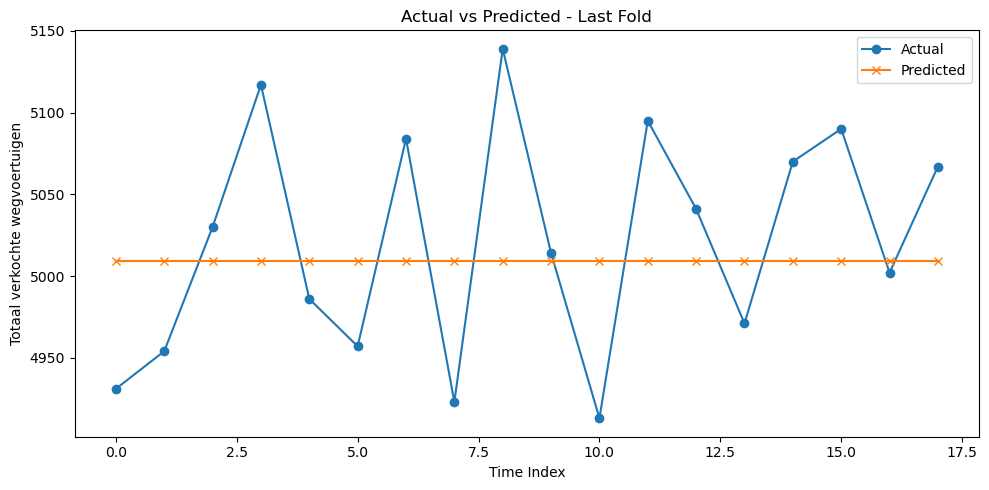

No feature importance to plot: model did not split on any features.


In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

# Simulate loading your dataset here
# df = pd.read_csv("your_data.csv")  # Replace with your actual dataset
# For this implementation, we assume df_lagged is already defined

# Copy original dataframe
df = df_lagged.copy()

# === 1. Preprocessing ===
# Log-transform the target to stabilize variance
df["target"] = np.log1p(df["Totaal_verkochte_wegvoertuigen"])

# Create time features
df["Periode"] = pd.to_datetime(df["Periode"])
df = df.sort_values("Periode").reset_index(drop=True)

# Create 12 lag features
for lag in range(1, 13):
    df[f"lag_{lag}"] = df["target"].shift(lag)

# Drop NA rows due to lagging
df = df.dropna().reset_index(drop=True)

# Define features and target
regressors = ["Bijtellingspercentage", "elektrische auto", "Consumentenvertrouwen"]
lag_features = [f"lag_{i}" for i in range(1, 13)]
features = regressors + lag_features
target = "target"

# Normalize regressors
scaler = StandardScaler()
df[regressors] = scaler.fit_transform(df[regressors])

X = df[features]
y = df[target]

# === 2. Model training & evaluation ===
tscv = TimeSeriesSplit(n_splits=5)
rmse_scores, mae_scores, r2_scores, mape_scores, ldsr_scores = [], [], [], [], []

for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = xgb.XGBRegressor(
        eta=0.1,
        max_depth=9,
        min_child_weight=50,
        gamma=0,
        subsample=0.7,
        colsample_bytree=0.7,
        reg_lambda=5,
        n_estimators=200,
        objective="reg:squarederror",
        random_state=42
    )
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    # Inverse log transform
    y_test_exp = np.expm1(y_test)
    y_pred_exp = np.expm1(y_pred)

    # Metrics
    rmse = np.sqrt(mean_squared_error(y_test_exp, y_pred_exp))
    mae = mean_absolute_error(y_test_exp, y_pred_exp)
    r2 = r2_score(y_test_exp, y_pred_exp)
    mape = np.mean(np.abs((y_test_exp - y_pred_exp) / y_test_exp)) * 100
    ldsr = np.mean(np.square(np.log1p(y_pred_exp) - np.log1p(y_test_exp)))

    rmse_scores.append(rmse)
    mae_scores.append(mae)
    r2_scores.append(r2)
    mape_scores.append(mape)
    ldsr_scores.append(ldsr)

# Show fold results as a DataFrame
results_df = pd.DataFrame({
    "Fold": [f"Fold {i+1}" for i in range(5)],
    "RMSE": rmse_scores,
    "MAE": mae_scores,
    "R²": r2_scores,
    "MAPE (%)": mape_scores,
    "LDSR": ldsr_scores
})
print(results_df)


import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(y_test_exp.values, label="Actual", marker='o')
plt.plot(y_pred_exp, label="Predicted", marker='x')
plt.title("Actual vs Predicted - Last Fold")
plt.xlabel("Time Index")
plt.ylabel("Totaal verkochte wegvoertuigen")
plt.legend()
plt.tight_layout()
plt.show()

# Only plot feature importance if the model has splits (feature importance is not empty)
importance = model.get_booster().get_score(importance_type='weight')
if importance:
    xgb.plot_importance(model, max_num_features=10)
    plt.show()
else:
    print("No feature importance to plot: model did not split on any features.")
    

In [9]:
xgb.plot_importance(model, max_num_features=10)
plt.show()


ValueError: Booster.get_score() results in empty.  This maybe caused by having all trees as decision dumps.

MAE         RMSE        R2       MAPE             Model
0  2436.523519  2908.684501 -0.274902  67.978796  LinearRegression
1  2436.407976  2908.533536 -0.274770  67.976212             Lasso
2  2431.759979  2902.523262 -0.269696  67.870175        ElasticNet
3  2436.368908  2908.475493 -0.274723  67.974686             Ridge
4  2947.064516  3593.264851 -0.983493  76.495814      DecisionTree
5  2276.740710  2708.058462 -0.108386  65.659506      RandomForest
6  2323.832317  2797.588875 -0.179428  66.231922          AdaBoost
7  2353.927742  2791.005281 -0.173996  65.769163               KNN
8  2272.510106  2640.125073 -0.048307  69.883933               SVR
9  2387.515088  2887.740957 -0.272677  64.487967           XGBoost

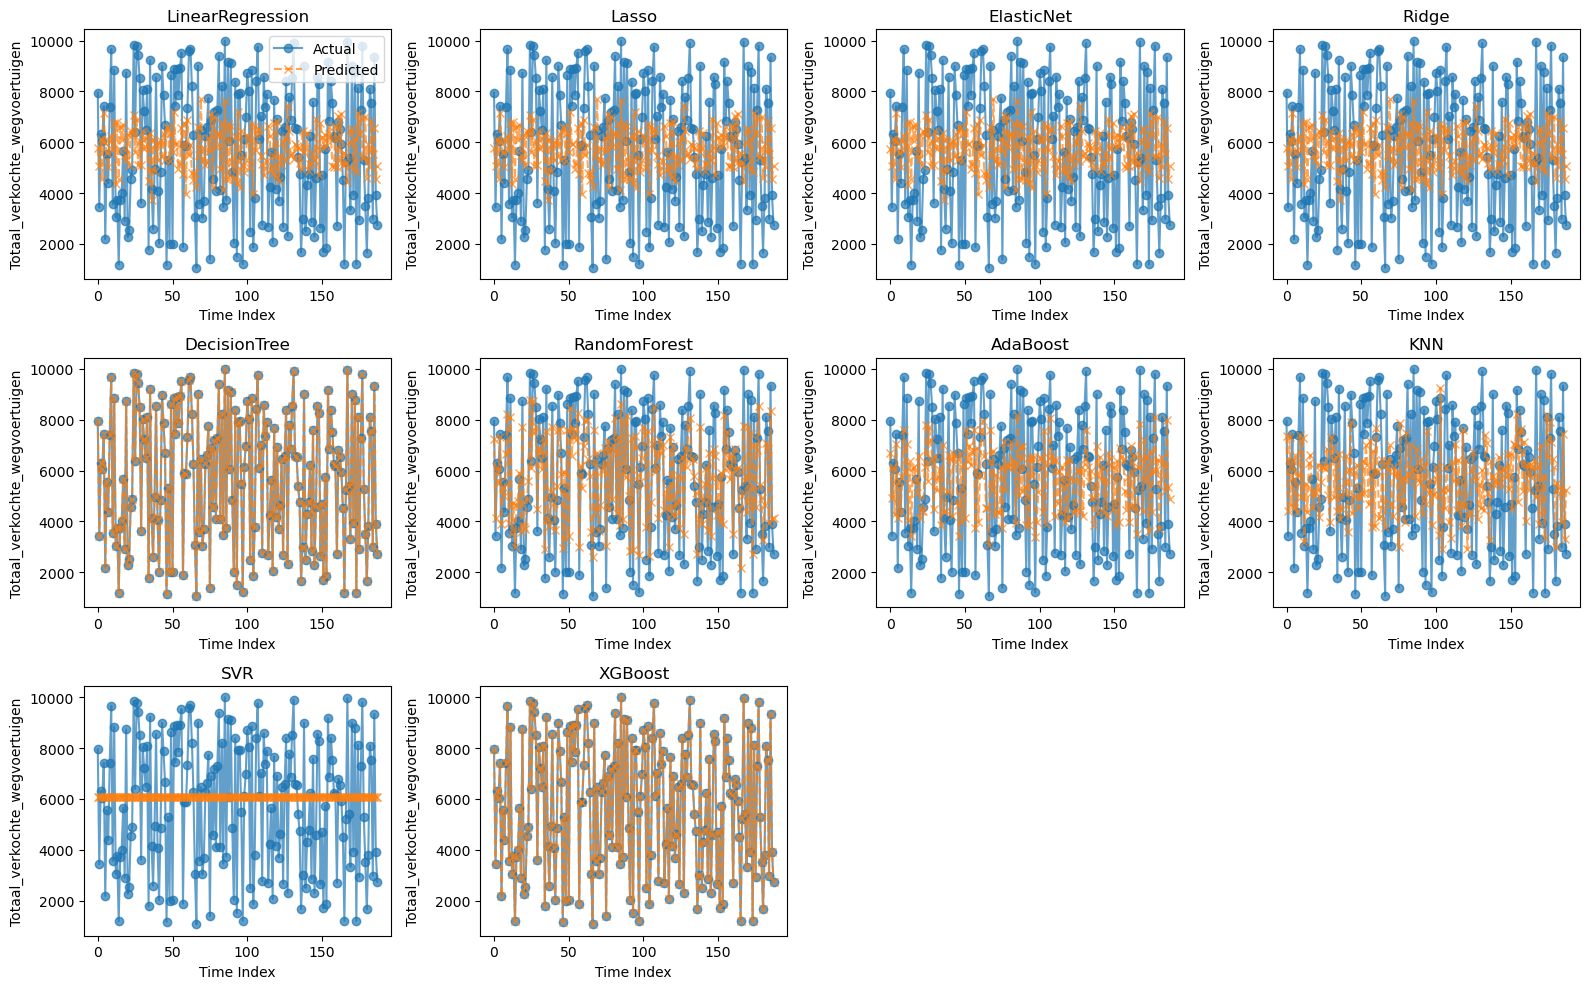

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
import xgboost as xgb

# Simulated DataFrame for demonstration
# Replace this with your actual df_lagged with lag features and regressors
np.random.seed(42)
n_rows = 200
df_lagged = pd.DataFrame({
    "Totaal_verkochte_wegvoertuigen": np.random.randint(1000, 10000, n_rows),
    "Bijtellingspercentage": np.random.rand(n_rows) * 10,
    "elektrische auto": np.random.rand(n_rows) * 100,
    "Consumentenvertrouwen": np.random.rand(n_rows) * 20
})
for lag in range(1, 13):
    df_lagged[f"lag_{lag}"] = df_lagged["Totaal_verkochte_wegvoertuigen"].shift(lag)
df_lagged.dropna(inplace=True)

# Define features and target
target_col = "Totaal_verkochte_wegvoertuigen"
regressors = ["Bijtellingspercentage", "elektrische auto", "Consumentenvertrouwen"]
lag_features = [f"lag_{i}" for i in range(1, 13)]
features = regressors + lag_features

X = df_lagged[features]
y = df_lagged[target_col]

# Models dictionary
models = {
    "LinearRegression": LinearRegression(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(),
    "Ridge": Ridge(),
    "DecisionTree": DecisionTreeRegressor(),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "AdaBoost": AdaBoostRegressor(n_estimators=100, random_state=42),
    "KNN": KNeighborsRegressor(),
    "SVR": SVR(),
    "XGBoost": xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
}

# Evaluation metrics
def evaluate_model(model, X, y):
    tscv = TimeSeriesSplit(n_splits=5)
    metrics = {"MAE": [], "RMSE": [], "R2": [], "MAPE": []}
    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        metrics["MAE"].append(mean_absolute_error(y_test, y_pred))
        metrics["RMSE"].append(np.sqrt(mean_squared_error(y_test, y_pred)))
        metrics["R2"].append(r2_score(y_test, y_pred))
        metrics["MAPE"].append(np.mean(np.abs((y_test - y_pred) / y_test)) * 100)
    return {k: np.mean(v) for k, v in metrics.items()}

# Run all models
results = []
for name, model in models.items():
    scores = evaluate_model(model, X, y)
    scores["Model"] = name
    results.append(scores)

# Convert to DataFrame for viewing
results_df = pd.DataFrame(results)
display(results_df)

import matplotlib.pyplot as plt

# Fit the best model (lowest RMSE) on all data and plot predictions vs actuals
best_model_name = results_df.loc[results_df["RMSE"].idxmin(), "Model"]
best_model = models[best_model_name]
best_model.fit(X, y)
y_pred = best_model.predict(X)

# Plot predictions vs actuals for every model
plt.figure(figsize=(16, 10))
for i, (name, model) in enumerate(models.items()):
    model.fit(X, y)
    y_pred = model.predict(X)
    plt.subplot(3, 4, i + 1)
    plt.plot(y.values, label="Actual", marker='o', linestyle='-', alpha=0.7)
    plt.plot(y_pred, label="Predicted", marker='x', linestyle='--', alpha=0.7)
    plt.title(name)
    plt.xlabel("Time Index")
    plt.ylabel(target_col)
    if i == 0:
        plt.legend()
plt.tight_layout()
plt.show()